<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Sergio Daniel Dueñas Godinez y Hector Cesar Ornelas León.

**Fecha:** 15 de Febrero del 2024.

**Expediente** : 739300 y 738146
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/SergioDuenass/Tarea3_SDDUENAS_HCORNELAS

# Tarea 3: Clase 7

## Enunciado de tarea
### Tarea 3


Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

~~~
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .
~~~

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

### Ejercicio 1: (enunciado) Transcribirlo

Código de solución estudiante 1

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
import itertools
from sklearn.preprocessing import power_transform
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Código de solución de estudiante 1

class LinearForecast1:

    #Inicializador
    def __init__(self, data):
        self.data = data

    # Usamos lo convertimos a serie de tiempo
    def timeSeries(self, target, dateColumn = 'date'):

        timeseries = self.data[[dateColumn, target]]
        timeseries.columns = ['date', 'y']
        timeseries['date'] = pd.to_datetime(timeseries['date'])
        timeseries = timeseries.set_index('date').resample('M').mean()
        self.timeseries = timeseries
        self.toUse = timeseries
        return self.timeseries.tail()

    # Debido al tamaño de los datos usaresmos fracciones
    def timeserieSlices(self, fraction = 1000):

        self.slice = fraction
        self.fraction = self.timeseries[:fraction]
        self.toUse = self.fraction

    # Visualizar Serie de Tiempo
    def plotTimeseries(self):

        return self.toUse.plot()

    # Función para el Dickey-Fuller
    def adf_test(self, useSelf = True, extra = ''):

        print("Results of Dickey-Fuller Test:")
        if useSelf:
            series = self.timeseries
        else:
            series = extra
        dftest = adfuller(series, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    # Graficarmos la autocorrelación y la autocorrelacion parcial
    def plot_acf_pacf(self, withDiff = 0, kwargs={'lags' : 40}, useSelf = True, extra = ''):

        f = plt.figure(figsize=(8,5))

        if useSelf:
            series = self.toUse
        else:
            series = extra

        for _ in range(withDiff):
            series = series.diff().dropna()

        ax1 = f.add_subplot(121)

        plot_acf(series, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(series, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    #Función para analisis de estacionalidad
    def seasonalDecompose(self, seasonality):

        self.seasonality = seasonality
        data1 = self.timeseries.copy()
        periods_seasonality = self.seasonality

        stl_kwargs = {"seasonal_deg": 0} 
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()
        self.res2 = res2

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        ax = res2.observed.to_frame('observados')[:self.slice].plot()

        res2.seasonal[:self.slice].plot(ax = ax)

    #Determinar Parametros
    def checkStationary(self):
        j = {}
        for i in self.seasonality:
            h = f'seasonal_{i}'
            print(h, '\n')
            j[h] = self.res2.seasonal[h]
            self.adf_test(useSelf = False, extra = j[h])
            print('Non-differentiated')
            self.plot_acf_pacf(useSelf = False, extra = j[h])
            print('Differentiated')
            self.plot_acf_pacf(withDiff=1, useSelf = False, extra = j[h])
            print('\n\n\n')
        self.j = j

    #Componente no estacional
    def nonStationalComponent(self, seasonality):

        self.adf_test(useSelf=False, extra=self.res2.observed)
        non_seasonal = self.res2.observed - self.res2.seasonal[f'seasonal_{seasonality}']
        non_seasonal.plot()
        self.adf_test(useSelf=False, extra = non_seasonal)
        print('Sin diferenciar')
        self.plot_acf_pacf(useSelf = False, extra = non_seasonal)
        print('diferenciado')
        self.plot_acf_pacf(withDiff=1, useSelf = False, extra = non_seasonal)
        print('diferenciado 2 veces')
        self.plot_acf_pacf(withDiff=2, useSelf = False, extra = non_seasonal)
        self.non_seasonal = non_seasonal
        self.chosenSeasonality = seasonality

    #Combinaciones de parametros
    def sarimax_params(self, p, d, q, P, D, Q, t=['n', 'c', 't', 'ct']):

        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], self.chosenSeasonality) for x in list(itertools.product(P, D, Q))]

        # Diferentes conmbinaciones
        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    #Escalamiento de datos usando yeo-johnson
    def scaleData(self):

        vals = power_transform(self.timeseries['y'].to_numpy().reshape(-1, 1), method='yeo-johnson')
        self.scaledData = vals
    
    #Encontrar parametros optimos
    def findParams(self):

        self.scaleData()
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index = np.arange(0, 11))

        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= par_no_season,
                seasonal_order= par_season
            )
            results = mod.fit()

            print(f'Parametros: {par_no_season}, {par_season}, {trend}')

            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.resultadosParams = resultados
        return self.resultadosParams

    #Reentrenar con los mejores parametros
    def sarimaxModel(self, no_season, season, trend):

        model = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= no_season,
                seasonal_order= season,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
        results = model.fit()
        self.sarimax = results
        return results.summary()

    #Predicción
    def prediction(self, size):

        end = len(self.timeseries)
        start = end-size
        actual = self.scaledData[start:end]
        predicted = self.sarimax.predict(start = start+1, end = end, dynamic = True)
        actual = actual.reshape(size,)
        assert actual.shape == predicted.shape

        self.actual = actual
        self.predicted = predicted

        predictions = pd.DataFrame({'actual': actual, 'predecido': predicted}, index=self.timeseries.index[start:end])

        fig, ax = plt.subplots(figsize=(12,8))
        predictions.actual.plot(ax = ax)
        predictions.predicted.plot(ax =ax)
        ax.legend(labels = ['actual', 'predicción'])

    #MAPE
    def emape(self):

        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)

        self.mape =  round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    #MAD
    def emad(self):

        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)

        # Calculate the MAPE value and return
        self.mad =  round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)

    #Métricas de error
    def errors(self):

        self.emape()
        self.emad()
        print(f'MAPE: {self.mape} \n MAD: {self.mad}')


### Ejercicio 2: 
Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

In [4]:
# Código de solución estudiante 1
url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
data = pd.read_excel(url)
data

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230
...,...,...,...,...,...,...,...,...,...,...,...,...
96995,8750,2014-12-31,2014,Dec,Wed,14,903,971,94,14.4875,8.8,925.713
96996,8751,2014-12-31,2014,Dec,Wed,15,746,950,76,14.2563,8.8,920.625
96997,8752,2014-12-31,2014,Dec,Wed,16,545,865,69,13.2500,8.6,854.471
96998,8753,2014-12-31,2014,Dec,Wed,17,308,599,80,13.0094,9.0,605.375


In [5]:
df = data.copy()
df['date'] = df.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
df.head()


,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01 06:00:00,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01 07:00:00,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01 08:00:00,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01 09:00:00,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01 10:00:00,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [6]:
LinearForecast = LinearForecast1(df)
LinearForecast.timeSeries('Energy (kWh)')

,y
date,
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674
2014-11-30,398.744335
2014-12-31,442.269996


<Axes: xlabel='date'>

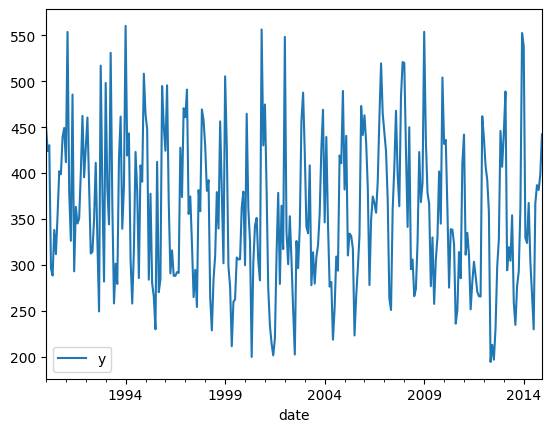

In [7]:
LinearForecast.timeserieSlices()
LinearForecast.plotTimeseries()

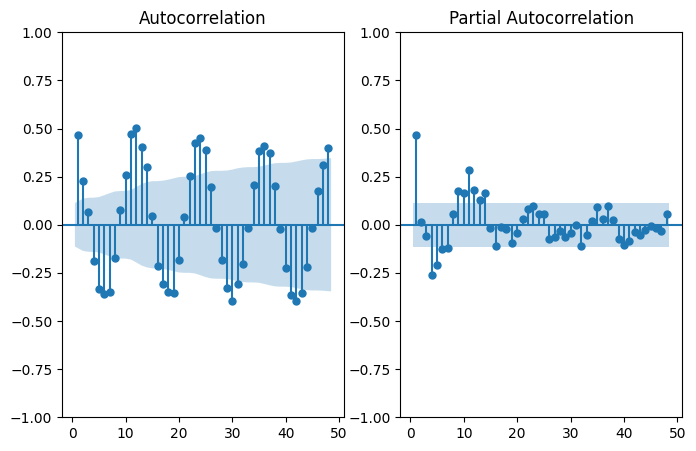

In [8]:
LinearForecast.plot_acf_pacf(kwargs={'lags': 48})

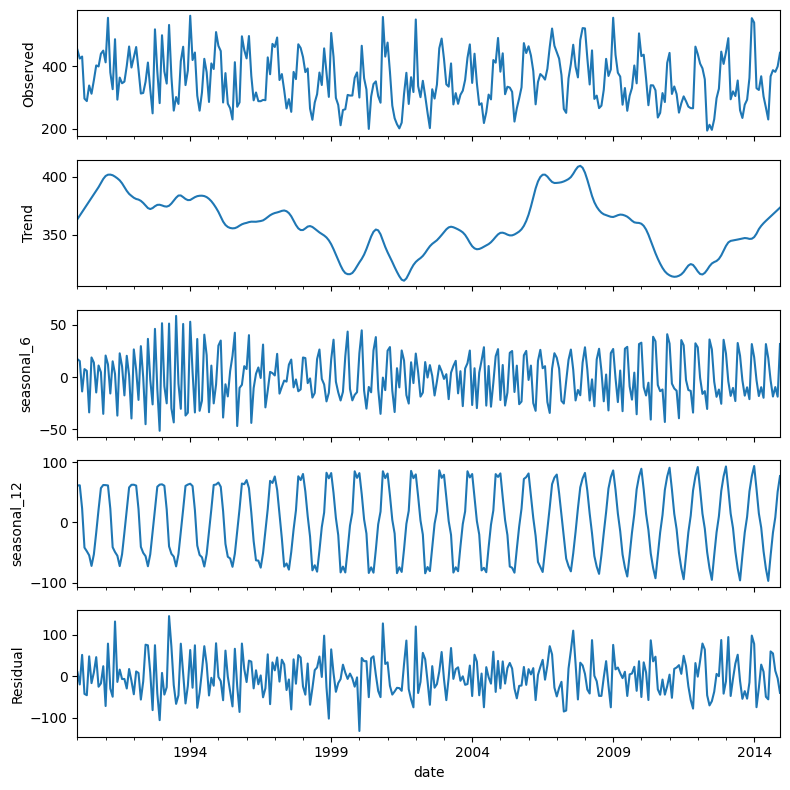

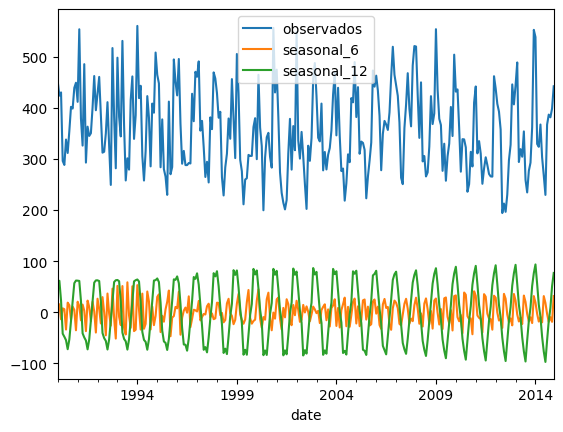

In [9]:
LinearForecast.seasonalDecompose((6, 12))

seasonal_6 

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary
Non-differentiated


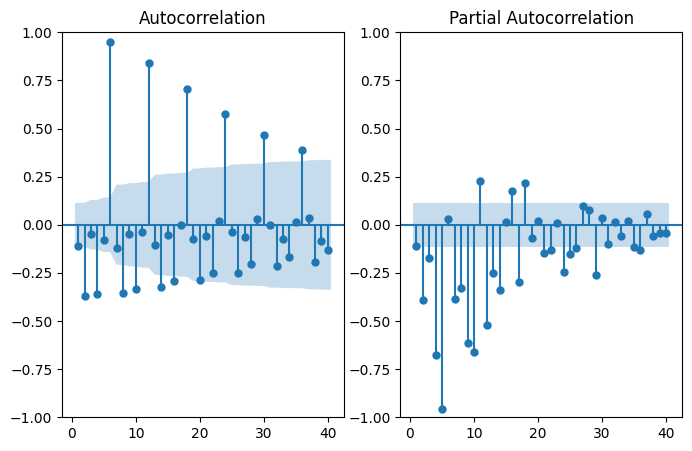

Differentiated


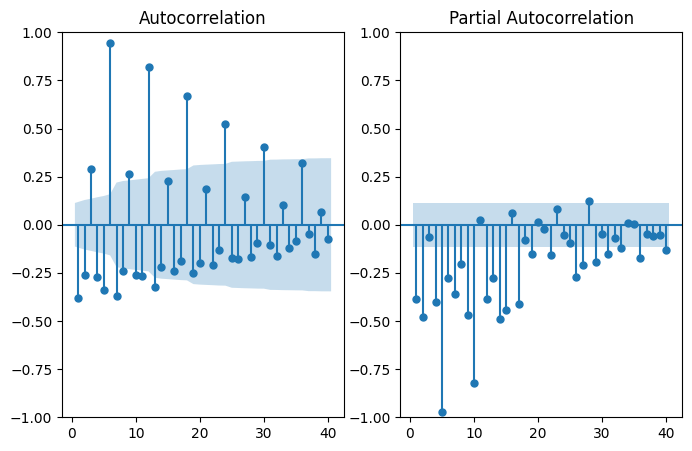





seasonal_12 

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary
Non-differentiated


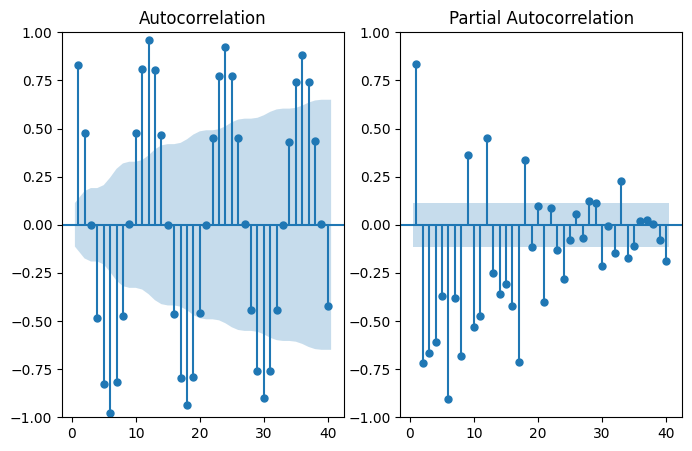

Differentiated


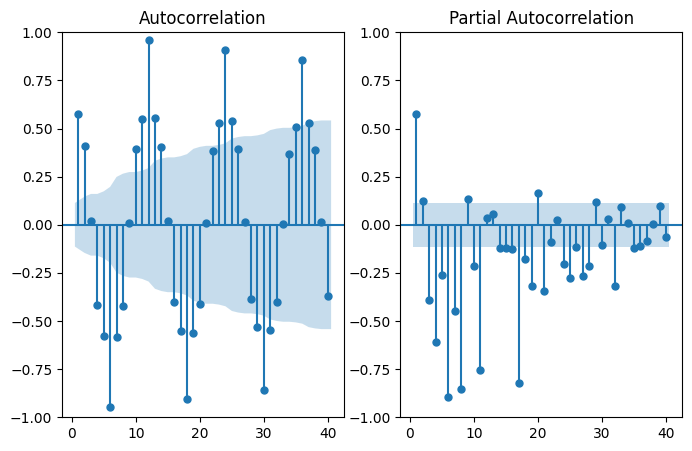

In [10]:
LinearForecast.checkStationary()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary
Sin diferenciar


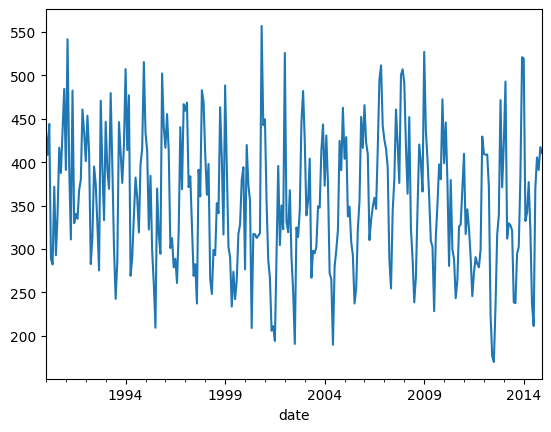

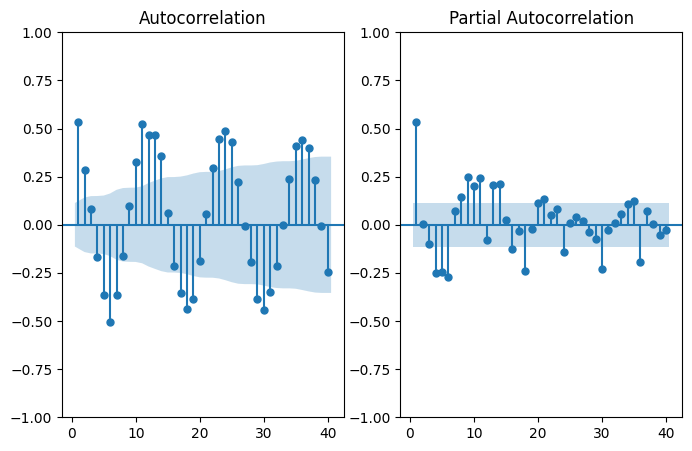

diferenciado


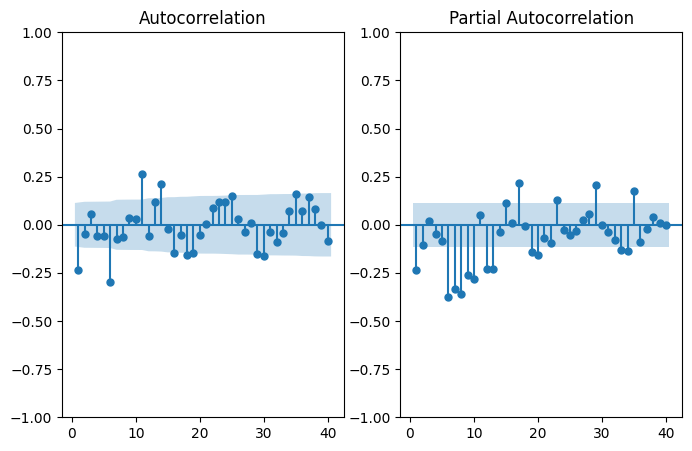

diferenciado 2 veces


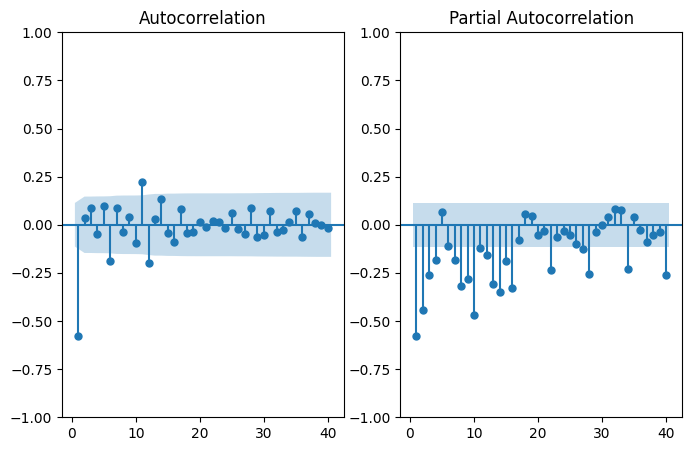

In [11]:
LinearForecast.nonStationalComponent(6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


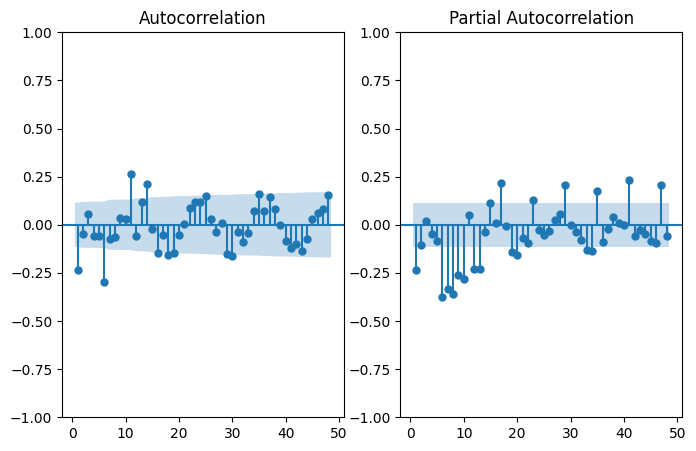

In [35]:
LinearForecast.adf_test(False, LinearForecast.non_seasonal.diff().dropna())
LinearForecast.plot_acf_pacf(1, {'lags': 48}, False, LinearForecast.non_seasonal)

Ya que tenemos una idea de los valores (p, d, q)x(P, D, Q, S), creamos una lista con todas las combinaciones posibles y entrenamos modelos SARIMAX con estos para encontrar el mejor

In [15]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0 ,1, 2]
D = [0]
Q = [0, 1, 2]
LinearForecast.sarimax_params(p, d, q, P, D, Q)

In [16]:
posibleParams = LinearForecast.findParams().sort_values(by=['AIC'], ascending=True)
posibleParams

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42026D+00    |proj g|=  3.30876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   9.811D-06   1.420D+00
  F =   1.4202567562318500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (0, 1, 0), (0, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     38      1     0     0   3.691D-03   1.419D+00
  F =   1.4190016522478810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 0), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42441D+00    |proj g|=  1.28609D-01

At iterate    5    f=  1.41210D+00    |proj g|=  1.01834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evalu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  1.38009D+00    |proj g|=  5.93885D-05

At iterate   50    f=  1.38009D+00    |proj g|=  2.89760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     63      1     0     0   2.898D-04   1.380D+00
  F =   1.3800858349392418     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 0), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42591D+00    |proj g|=  1.39564D-01

At iterate    5    f=  1.41694

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Parametros: (0, 1, 0), (1, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42589D+00    |proj g|=  1.39529D-01

At iterate    5    f=  1.41736D+00    |proj g|=  1.34606D+00

At iterate   10    f=  1.41732D+00    |proj g|=  6.71130D-02

At iterate   15    f=  1.41725D+00    |proj g|=  1.22521D-01

At iterate   20    f=  1.40295D+00    |proj g|=  8.16200D+00

At iterate   25    f=  1.38995D+00    |proj g|=  7.82206D-01

At iterate   30    f=  1.38711D+00    |proj g|=  3.40317D-01

At iterate   35    f=  1.38160D+00    |proj g|=  4.28033D-01

At iterate   40    f=  1.38037D+00    |proj g|=  1.59598D-01

At iterate   45    f=  1.38020D+00    |proj g|=  1.08430D-02

At iterate   50    f=  1.38012D+00    |proj g|=  2.40155D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total

 This problem is unconstrained.



At iterate    5    f=  1.41732D+00    |proj g|=  1.48323D+00

At iterate   10    f=  1.41726D+00    |proj g|=  6.45448D-02

At iterate   15    f=  1.41719D+00    |proj g|=  1.18162D-02

At iterate   20    f=  1.41707D+00    |proj g|=  6.52386D-01

At iterate   25    f=  1.40019D+00    |proj g|=  7.05509D+00

At iterate   30    f=  1.38571D+00    |proj g|=  2.24022D+00

At iterate   35    f=  1.38141D+00    |proj g|=  3.27195D-02

At iterate   40    f=  1.38117D+00    |proj g|=  3.22762D-02

At iterate   45    f=  1.38115D+00    |proj g|=  2.10346D-01

At iterate   50    f=  1.38060D+00    |proj g|=  4.27636D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.40712D+00    |proj g|=  1.03022D-01

At iterate   15    f=  1.38796D+00    |proj g|=  1.69191D-02

At iterate   20    f=  1.37971D+00    |proj g|=  2.52421D-02

At iterate   25    f=  1.37827D+00    |proj g|=  2.83490D-03

At iterate   30    f=  1.37806D+00    |proj g|=  7.53049D-04

At iterate   35    f=  1.37803D+00    |proj g|=  1.47067D-04

At iterate   40    f=  1.37802D+00    |proj g|=  9.73109D-04

At iterate   45    f=  1.37802D+00    |proj g|=  2.64129D-04

At iterate   50    f=  1.37802D+00    |proj g|=  2.66220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     57   

 This problem is unconstrained.



At iterate    5    f=  1.41109D+00    |proj g|=  4.72634D-03

At iterate   10    f=  1.40170D+00    |proj g|=  9.68971D-02

At iterate   15    f=  1.38507D+00    |proj g|=  2.50041D-02

At iterate   20    f=  1.37888D+00    |proj g|=  4.85554D-03

At iterate   25    f=  1.37814D+00    |proj g|=  1.69910D-03

At iterate   30    f=  1.37804D+00    |proj g|=  9.24043D-04

At iterate   35    f=  1.37803D+00    |proj g|=  2.32600D-04

At iterate   40    f=  1.37802D+00    |proj g|=  7.14150D-04

At iterate   45    f=  1.37802D+00    |proj g|=  7.08114D-04

At iterate   50    f=  1.37802D+00    |proj g|=  1.95317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.37915D+00    |proj g|=  1.79175D-02

At iterate   30    f=  1.37820D+00    |proj g|=  2.67286D-02

At iterate   35    f=  1.37806D+00    |proj g|=  2.76973D-02

At iterate   40    f=  1.37803D+00    |proj g|=  1.14559D-02

At iterate   45    f=  1.37802D+00    |proj g|=  1.98631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     60      1     0     0   1.986D-03   1.378D+00
  F =   1.3780196796481654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 0), (1, 0, 2, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.



At iterate   15    f=  1.41130D+00    |proj g|=  5.37751D-01

At iterate   20    f=  1.41110D+00    |proj g|=  3.63660D-02

At iterate   25    f=  1.41105D+00    |proj g|=  5.23135D-02

At iterate   30    f=  1.40969D+00    |proj g|=  6.91187D-01

At iterate   35    f=  1.39306D+00    |proj g|=  1.36934D+00

At iterate   40    f=  1.39253D+00    |proj g|=  4.44391D-01

At iterate   45    f=  1.38601D+00    |proj g|=  6.93939D-01

At iterate   50    f=  1.37961D+00    |proj g|=  1.51608D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.516D-01   1.380D+00
  F =   1.37960544447

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     18      1     0     0   1.969D-02   1.411D+00
  F =   1.4106630290831366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 0), (2, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41346D+00    |proj g|=  8.29836D-02

At iterate    5    f=  1.40919D+00    |proj g|=  1.05958D-02

At iterate   10    f=  1.40056D+00    |proj g|=  8.09077D-02

At iterate   15    f=  1.3837


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f=  1.37796D+00    |proj g|=  4.01438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58      1     0     0   4.014D-04   1.378D+00
  F =   1.3779571100345673     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 0), (2, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41341D+00    |proj g|=  8.01790D-02

At iterate    5    f=  1.40906D+00    |proj g|=  1.59398D-02

At iterate   10    f=  1.39322

 This problem is unconstrained.



At iterate   40    f=  1.37796D+00    |proj g|=  5.33067D-04

At iterate   45    f=  1.37796D+00    |proj g|=  3.87548D-04

At iterate   50    f=  1.37796D+00    |proj g|=  4.23829D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   4.238D-04   1.378D+00
  F =   1.3779567528904855     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 0), (2, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41340

 This problem is unconstrained.



At iterate   25    f=  1.40931D+00    |proj g|=  1.85853D-02

At iterate   30    f=  1.40929D+00    |proj g|=  2.43643D-01

At iterate   35    f=  1.40516D+00    |proj g|=  4.99350D+00

At iterate   40    f=  1.39262D+00    |proj g|=  1.10444D-01

At iterate   45    f=  1.38226D+00    |proj g|=  1.13591D+00

At iterate   50    f=  1.37887D+00    |proj g|=  2.97520D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   2.975D-01   1.379D+00
  F =   1.3788727391492246     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 0), (2, 0, 1, 6), t
RUNNING THE 

 This problem is unconstrained.



At iterate    5    f=  1.41021D+00    |proj g|=  4.93744D+00

At iterate   10    f=  1.40939D+00    |proj g|=  2.61986D-02

At iterate   15    f=  1.40934D+00    |proj g|=  1.17192D-01

At iterate   20    f=  1.40932D+00    |proj g|=  4.67922D-02

At iterate   25    f=  1.40764D+00    |proj g|=  9.33310D-01

At iterate   30    f=  1.39386D+00    |proj g|=  1.45122D+00

At iterate   35    f=  1.38759D+00    |proj g|=  2.02550D+00

At iterate   40    f=  1.38666D+00    |proj g|=  2.71846D-02

At iterate   45    f=  1.38649D+00    |proj g|=  8.36724D-01

At iterate   50    f=  1.38347D+00    |proj g|=  3.15611D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.37625D+00    |proj g|=  2.67735D-03

At iterate   35    f=  1.37623D+00    |proj g|=  3.28881D-04

At iterate   40    f=  1.37621D+00    |proj g|=  1.30184D-03

At iterate   45    f=  1.37621D+00    |proj g|=  6.42770D-04

At iterate   50    f=  1.37621D+00    |proj g|=  8.86869D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   8.869D-05   1.376D+00
  F =   1.3762063400261171     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 0), (2, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.



At iterate   10    f=  1.38785D+00    |proj g|=  9.26988D-02

At iterate   15    f=  1.37665D+00    |proj g|=  2.52195D-02

At iterate   20    f=  1.37633D+00    |proj g|=  1.82656D-04

At iterate   25    f=  1.37633D+00    |proj g|=  1.58291D-04

At iterate   30    f=  1.37633D+00    |proj g|=  2.01130D-03

At iterate   35    f=  1.37629D+00    |proj g|=  1.04825D-02

At iterate   40    f=  1.37626D+00    |proj g|=  6.59754D-04

At iterate   45    f=  1.37623D+00    |proj g|=  8.63225D-04

At iterate   50    f=  1.37622D+00    |proj g|=  2.72585D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   30    f=  1.40594D+00    |proj g|=  2.85630D-02

At iterate   35    f=  1.40573D+00    |proj g|=  3.25420D-01

At iterate   40    f=  1.39966D+00    |proj g|=  1.07788D+01

At iterate   45    f=  1.37772D+00    |proj g|=  9.94221D-02

At iterate   50    f=  1.37726D+00    |proj g|=  1.42710D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   1.427D+00   1.377D+00
  F =   1.3772591223639232     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 0), (2, 0, 2, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.



At iterate   10    f=  1.40735D+00    |proj g|=  8.27374D-02

At iterate   15    f=  1.40703D+00    |proj g|=  7.94950D-01

At iterate   20    f=  1.40624D+00    |proj g|=  1.24963D-02

At iterate   25    f=  1.40592D+00    |proj g|=  1.00530D-01

At iterate   30    f=  1.39903D+00    |proj g|=  7.21104D+00

At iterate   35    f=  1.39073D+00    |proj g|=  1.76752D+00

At iterate   40    f=  1.38348D+00    |proj g|=  1.94221D+00

At iterate   45    f=  1.38229D+00    |proj g|=  7.18571D-01

At iterate   50    f=  1.38219D+00    |proj g|=  8.08834D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     37      2     0     0   3.336D-02   1.378D+00
  F =   1.3781677766215903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (0, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38829D+00    |proj g|=  2.41715D-01

At iterate    5    f=  1.36025D+00    |proj g|=  2.50811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evalu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Parametros: (0, 1, 1), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38822D+00    |proj g|=  8.99113D-01

At iterate    5    f=  1.38414D+00    |proj g|=  1.68679D+01

At iterate   10    f=  1.36792D+00    |proj g|=  7.23315D-02

At iterate   15    f=  1.36480D+00    |proj g|=  1.83184D+00

At iterate   20    f=  1.36311D+00    |proj g|=  1.81108D-01

At iterate   25    f=  1.36010D+00    |proj g|=  4.88133D-01

At iterate   30    f=  1.36010D+00    |proj g|=  1.45164D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.29438D+00    |proj g|=  3.78297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   2.196D-06   1.294D+00
  F =   1.2943176030127128     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (0, 1, 1), (0, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38779D+00    |proj g|=  2.47432D-01

At iterate    5    f=  1.32391D+00    |proj g|=  1.16018D-01

At iterate   10    f=  1.29649

 This problem is unconstrained.



At iterate   30    f=  1.32063D+00    |proj g|=  1.61302D+01

At iterate   35    f=  1.30433D+00    |proj g|=  9.99864D+00

At iterate   40    f=  1.29789D+00    |proj g|=  4.25199D+00

At iterate   45    f=  1.29514D+00    |proj g|=  1.97024D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     98      1     0     0   1.850D+01   1.295D+00
  F =   1.2951420004977121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (0, 0, 2, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37034D+00    |proj g|=  1.15440D-01

At iterate    5    f=  1.30640D+00    |proj g|=  6.75284D-02

At iterate   10    f=  1.29703D+00    |proj g|=  1.48341D-04

           * * *

Tit   = tot


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     21      1     0     0   1.154D-01   1.370D+00
  F =   1.3702802138335093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (1, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39106D+00    |proj g|=  2.83906D-01

At iterate    5    f=  1.22121D+00    |proj g|=  1.65592D-01

At iterate   10    f=  1.18575D+00    |proj g|=  2.58094D-02

At iterate   15    f=  1.1723

 This problem is unconstrained.



At iterate   20    f=  1.34675D+00    |proj g|=  2.80337D-01

At iterate   25    f=  1.34606D+00    |proj g|=  2.09144D+00

At iterate   30    f=  1.32468D+00    |proj g|=  3.02742D+01

At iterate   35    f=  1.24907D+00    |proj g|=  8.35346D+01

At iterate   40    f=  1.20146D+00    |proj g|=  3.44668D+02

At iterate   45    f=  1.17107D+00    |proj g|=  1.52479D+01

At iterate   50    f=  1.16149D+00    |proj g|=  1.49424D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.494D+01   1.161D+00
  F =   1.1614919204547964     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.35779D+00    |proj g|=  9.27506D+00

At iterate   20    f=  1.34669D+00    |proj g|=  3.25301D-01

At iterate   25    f=  1.27720D+00    |proj g|=  8.56791D+00

At iterate   30    f=  1.24983D+00    |proj g|=  1.11236D+02

At iterate   35    f=  1.21971D+00    |proj g|=  1.22777D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  1.20191D+00    |proj g|=  8.63545D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41    107      2     0     0   8.635D-01   1.202D+00
  F =   1.2019052530323373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38859D+00    |proj g|=  2.81514D-01

At iterate    5    f=  1.27525D+00    |proj g|=  1.52591D-01

At iterate   10    f=  1.1884

 This problem is unconstrained.



At iterate   25    f=  1.16295D+00    |proj g|=  4.47394D+00

At iterate   30    f=  1.14997D+00    |proj g|=  1.69874D-01

At iterate   35    f=  1.14755D+00    |proj g|=  3.09497D-02

At iterate   40    f=  1.14739D+00    |proj g|=  7.98813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     53      1     0     0   9.807D-04   1.147D+00
  F =   1.1473889615915667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (1, 0, 2, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   10    f=  1.35574D+00    |proj g|=  2.19574D+01

At iterate   15    f=  1.34841D+00    |proj g|=  2.10404D-01

At iterate   20    f=  1.32999D+00    |proj g|=  2.21928D+00

At iterate   25    f=  1.32654D+00    |proj g|=  3.56739D+00

At iterate   30    f=  1.28960D+00    |proj g|=  4.72838D+00

At iterate   35    f=  1.28877D+00    |proj g|=  1.51253D+00

At iterate   40    f=  1.28361D+00    |proj g|=  1.87508D+00

At iterate   45    f=  1.24375D+00    |proj g|=  7.12139D+01

At iterate   50    f=  1.23609D+00    |proj g|=  3.49350D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57   

 This problem is unconstrained.



At iterate   20    f=  1.33061D+00    |proj g|=  1.46271D-01

At iterate   25    f=  1.32788D+00    |proj g|=  2.31963D+00

At iterate   30    f=  1.29806D+00    |proj g|=  9.18296D+00

At iterate   35    f=  1.28908D+00    |proj g|=  9.60660D+00

At iterate   40    f=  1.28466D+00    |proj g|=  4.87553D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  1.28203D+00    |proj g|=  4.81460D+01

At iterate   50    f=  1.27169D+00    |proj g|=  2.15701D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     82      2     0     0   2.157D-01   1.272D+00
  F =   1.2716887242308246     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (0, 1, 1), (1, 0, 2, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35102D+00    |proj g|=  9.21661D-02

At iterate    5    f=  1.2445

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.15553D+00    |proj g|=  3.31675D-03

At iterate   25    f=  1.15544D+00    |proj g|=  2.28491D-04

At iterate   30    f=  1.14343D+00    |proj g|=  4.31898D-02

At iterate   35    f=  1.13038D+00    |proj g|=  3.68445D-03

At iterate   40    f=  1.12953D+00    |proj g|=  2.45937D-03

At iterate   45    f=  1.12943D+00    |proj g|=  8.62632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     65      1     0     0   6.586D-05   1.129D+00
  F =   1.1294266537156239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (2, 0, 1, 6), n
RUNNING THE 

 This problem is unconstrained.



At iterate    5    f=  1.24041D+00    |proj g|=  3.31721D-01

At iterate   10    f=  1.20156D+00    |proj g|=  7.24724D-01

At iterate   15    f=  1.17566D+00    |proj g|=  5.48642D-01

At iterate   20    f=  1.15499D+00    |proj g|=  1.65223D-01

At iterate   25    f=  1.14758D+00    |proj g|=  4.38557D-01

At iterate   30    f=  1.14618D+00    |proj g|=  1.71686D-02

At iterate   35    f=  1.14613D+00    |proj g|=  4.67970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     51      1     0     0   4.680D-03   1.146D+00
  F =   1.1461260074312369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   35    f=  1.23672D+00    |proj g|=  4.63948D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     82      2     0     0   3.697D+00   1.235D+00
  F =   1.2345741861172912     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Parametros: (0, 1, 1), (2, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36145D+00    |proj g|=  7.82097D-01

At iterate    5    f=  1.36132D+00    |proj g|=  2.36508D+00

At iterate   10    f=  1.35079D+00    |proj g|=  2.47696D+01

At iterate   15    f=  1.31663

 This problem is unconstrained.


At iterate    5    f=  1.19263D+00    |proj g|=  6.99864D-01

At iterate   10    f=  1.14457D+00    |proj g|=  1.26298D-02

At iterate   15    f=  1.13281D+00    |proj g|=  6.56903D-02

At iterate   20    f=  1.12657D+00    |proj g|=  5.74362D-03

At iterate   25    f=  1.12653D+00    |proj g|=  4.22735D-04

At iterate   30    f=  1.12653D+00    |proj g|=  1.65096D-04

At iterate   35    f=  1.12651D+00    |proj g|=  6.45849D-04

At iterate   40    f=  1.12647D+00    |proj g|=  3.36294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     52      1     0     0   7.005D-06   1.126D+00
  F =   1.126470965362

 This problem is unconstrained.



At iterate   15    f=  1.17425D+00    |proj g|=  9.85228D-02

At iterate   20    f=  1.14747D+00    |proj g|=  4.39837D+00

At iterate   25    f=  1.14558D+00    |proj g|=  3.08271D-01

At iterate   30    f=  1.14557D+00    |proj g|=  3.87304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     43      1     0     0   3.874D-03   1.146D+00
  F =   1.1455679166923090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (2, 0, 2, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   30    f=  1.22160D+00    |proj g|=  3.65051D+00

At iterate   35    f=  1.22155D+00    |proj g|=  4.15559D+00

At iterate   40    f=  1.22146D+00    |proj g|=  1.28745D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     59      1     0     0   1.287D+01   1.221D+00
  F =   1.2214590566310588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (0, 1, 1), (2, 0, 2, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39262


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.39088D+00    |proj g|=  1.15127D+01

At iterate   10    f=  1.34136D+00    |proj g|=  1.91607D+01

At iterate   15    f=  1.33637D+00    |proj g|=  6.47579D+00

At iterate   20    f=  1.30583D+00    |proj g|=  4.73470D-01

At iterate   25    f=  1.30582D+00    |proj g|=  1.89094D+00

At iterate   30    f=  1.30378D+00    |proj g|=  2.27169D+01

At iterate   35    f=  1.29575D+00    |proj g|=  2.70706D+00

At iterate   40    f=  1.29510D+00    |proj g|=  7.98267D+00

At iterate   45    f=  1.25127D+00    |proj g|=  2.66031D+01

At iterate   50    f=  1.22115D+00    |proj g|=  5.50095D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   4.264D-06   1.386D+00
  F =   1.3862081315842278     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 0), (0, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38619D+00    |proj g|=  1.70537D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.36449D+00    |proj g|=  5.94506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   5.021D-06   1.364D+00
  F =   1.3644938405699603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 0), (0, 0, 2, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39406D+00    |proj g|=  2.10652D-01

At iterate    5    f=  1.36506D+00    |proj g|=  1.09357D-01

At iterate   10    f=  1.36449

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.36443D+00    |proj g|=  1.65793D-03

At iterate   15    f=  1.36443D+00    |proj g|=  2.86625D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     27      1     0     0   4.957D-03   1.364D+00
  F =   1.3644270087904564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (0, 0, 2, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38019D+00    |proj g|=  8.16272D-02

At iterate    5    f=  1.3756


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   25    f=  1.37561D+00    |proj g|=  1.86311D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     51      1     0     0   3.658D-02   1.376D+00
  F =   1.3756065878121051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (1, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39689D+00    |proj g|=  2.40554D-01

At iterate    5    f=  1.36871D+00    |proj g|=  3.14565D-02

At iterate   10    f=  1.3169


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  1.29752D+00    |proj g|=  1.28742D-04

At iterate   50    f=  1.29752D+00    |proj g|=  7.69484D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     59      1     0     0   7.695D-05   1.298D+00
  F =   1.2975171193068908     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 0), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39689D+00    |proj g|=  2.40554D-01

At iterate    5    f=  1.36871

 This problem is unconstrained.



At iterate   50    f=  1.29793D+00    |proj g|=  3.62530D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   3.625D-02   1.298D+00
  F =   1.2979261141238643     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 0), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39678D+00    |proj g|=  2.40516D-01

At iterate    5    f=  1.37385D+00    |proj g|=  9.95206D-01

At iterate   10    f=  1.37381

 This problem is unconstrained.



At iterate   40    f=  1.30190D+00    |proj g|=  2.41713D-01

At iterate   45    f=  1.29893D+00    |proj g|=  3.81876D-01

At iterate   50    f=  1.29858D+00    |proj g|=  1.05335D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   1.053D-02   1.299D+00
  F =   1.2985814317614435     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 0), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3948

 This problem is unconstrained.


At iterate   30    f=  1.29607D+00    |proj g|=  3.19425D-04

At iterate   35    f=  1.29607D+00    |proj g|=  5.50551D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     40      1     0     0   5.506D-06   1.296D+00
  F =   1.2960718722520925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 0), (1, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39480D+00    |proj g|=  2.39165D-01

At iterate    5    f=  1.36026D

 This problem is unconstrained.



At iterate   20    f=  1.29780D+00    |proj g|=  1.47758D-02

At iterate   25    f=  1.29621D+00    |proj g|=  1.76769D-03

At iterate   30    f=  1.29610D+00    |proj g|=  6.57709D-04

At iterate   35    f=  1.29607D+00    |proj g|=  2.41251D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   2.449D-05   1.296D+00
  F =   1.2960717491419662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (1, 0, 2, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   15    f=  1.36202D+00    |proj g|=  1.60597D+00

At iterate   20    f=  1.36138D+00    |proj g|=  4.15945D-02

At iterate   25    f=  1.36088D+00    |proj g|=  1.02676D+00

At iterate   30    f=  1.36064D+00    |proj g|=  1.27449D-02

At iterate   35    f=  1.36056D+00    |proj g|=  4.67120D-01

At iterate   40    f=  1.36021D+00    |proj g|=  4.96804D-02

At iterate   45    f=  1.36019D+00    |proj g|=  1.42978D-01

At iterate   50    f=  1.35988D+00    |proj g|=  1.28540D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   1.285D-01   1.360D+00
  F =   1.35988377882

 This problem is unconstrained.



At iterate   20    f=  1.36133D+00    |proj g|=  1.05350D-01

At iterate   25    f=  1.36075D+00    |proj g|=  9.12504D-02

At iterate   30    f=  1.36046D+00    |proj g|=  4.30598D-01

At iterate   35    f=  1.35957D+00    |proj g|=  2.95991D-01

At iterate   40    f=  1.32543D+00    |proj g|=  2.32844D+00

At iterate   45    f=  1.31018D+00    |proj g|=  2.50079D+00

At iterate   50    f=  1.30460D+00    |proj g|=  2.47099D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   2.471D-01   1.305D+00
  F =   1.3045967938269951     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.35858D+00    |proj g|=  5.67356D-02

At iterate   20    f=  1.35695D+00    |proj g|=  1.12152D-02

At iterate   25    f=  1.35692D+00    |proj g|=  5.70717D-01

At iterate   30    f=  1.35686D+00    |proj g|=  2.35744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   2.357D-03   1.357D+00
  F =   1.3568552885357372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (2, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   20    f=  1.35691D+00    |proj g|=  2.17165D-02

At iterate   25    f=  1.35690D+00    |proj g|=  1.69645D-02

At iterate   30    f=  1.35681D+00    |proj g|=  4.00438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     47      1     0     0   9.843D-04   1.357D+00
  F =   1.3568084846756754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (2, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3729


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.30099D+00    |proj g|=  2.36054D-02

At iterate   20    f=  1.29647D+00    |proj g|=  2.15805D-02

At iterate   25    f=  1.29609D+00    |proj g|=  3.41653D-04

At iterate   30    f=  1.29606D+00    |proj g|=  1.74630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   3.206D-06   1.296D+00
  F =   1.2960626645139601     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 0), (2, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   15    f=  1.30099D+00    |proj g|=  2.34826D-02

At iterate   20    f=  1.29647D+00    |proj g|=  2.05539D-02

At iterate   25    f=  1.29608D+00    |proj g|=  1.54528D-03

At iterate   30    f=  1.29606D+00    |proj g|=  6.31464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   5.742D-06   1.296D+00
  F =   1.2960625422969672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 0), (2, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   15    f=  1.35446D+00    |proj g|=  7.20314D-02

At iterate   20    f=  1.35410D+00    |proj g|=  1.56364D-01

At iterate   25    f=  1.35409D+00    |proj g|=  3.83034D-01

At iterate   30    f=  1.35331D+00    |proj g|=  3.82614D+00

At iterate   35    f=  1.35121D+00    |proj g|=  2.30057D-01

At iterate   40    f=  1.35097D+00    |proj g|=  4.73851D-01

At iterate   45    f=  1.34735D+00    |proj g|=  1.49950D+00

At iterate   50    f=  1.34564D+00    |proj g|=  6.66010D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   6.660D-01   1.346D+00
  F =   1.34563575022

 This problem is unconstrained.



At iterate   25    f=  1.35406D+00    |proj g|=  1.66347D-02

At iterate   30    f=  1.35405D+00    |proj g|=  5.40590D-01

At iterate   35    f=  1.35288D+00    |proj g|=  1.63492D+00

At iterate   40    f=  1.35200D+00    |proj g|=  7.61710D-02

At iterate   45    f=  1.33421D+00    |proj g|=  2.24062D+00

At iterate   50    f=  1.30934D+00    |proj g|=  4.75621D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   4.756D-01   1.309D+00
  F =   1.3093368726353503     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 0), (2, 0, 1, 6), ct
RUNNING THE

 This problem is unconstrained.



At iterate   35    f=  1.29261D+00    |proj g|=  4.69363D-04

At iterate   40    f=  1.29261D+00    |proj g|=  1.83956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     48      1     0     0   4.641D-05   1.293D+00
  F =   1.2926111888896288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (2, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39816D+00    |proj g|=  2.43749D-01

At iterate    5    f=  1.33886

 This problem is unconstrained.



At iterate   20    f=  1.29273D+00    |proj g|=  4.29437D-03

At iterate   25    f=  1.29267D+00    |proj g|=  1.08277D-02

At iterate   30    f=  1.29265D+00    |proj g|=  6.46892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   5.558D-05   1.293D+00
  F =   1.2926517024432327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 0), (2, 0, 2, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39813

 This problem is unconstrained.



At iterate   15    f=  1.35368D+00    |proj g|=  2.84394D-01

At iterate   20    f=  1.34822D+00    |proj g|=  5.16411D-02

At iterate   25    f=  1.32895D+00    |proj g|=  1.06506D+00

At iterate   30    f=  1.31331D+00    |proj g|=  2.38950D+00

At iterate   35    f=  1.30504D+00    |proj g|=  2.86386D+01

At iterate   40    f=  1.30317D+00    |proj g|=  3.81625D+00

At iterate   45    f=  1.30098D+00    |proj g|=  4.46144D+00

At iterate   50    f=  1.29897D+00    |proj g|=  4.86381D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   4.864D+00   1.299D+00
  F =   1.29897272199

 This problem is unconstrained.



At iterate   25    f=  1.34801D+00    |proj g|=  3.39937D+00

At iterate   30    f=  1.34566D+00    |proj g|=  2.96542D-01

At iterate   35    f=  1.34563D+00    |proj g|=  2.19864D-01

At iterate   40    f=  1.34492D+00    |proj g|=  2.52387D-01

At iterate   45    f=  1.34472D+00    |proj g|=  8.35172D-01

At iterate   50    f=  1.34133D+00    |proj g|=  1.02336D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   1.023D+00   1.341D+00
  F =   1.3413307566880110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 0), (2, 0, 2, 6), ct
RUNNING THE

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     19      1     0     0   4.724D-02   1.376D+00
  F =   1.3756292034830857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (0, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37559D+00    |proj g|=  2.10658D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.27572D+00    |proj g|=  3.65483D-01

At iterate   25    f=  1.27261D+00    |proj g|=  1.92361D-01

At iterate   30    f=  1.27192D+00    |proj g|=  2.73148D-01

At iterate   35    f=  1.27184D+00    |proj g|=  6.28243D-01

At iterate   40    f=  1.27175D+00    |proj g|=  2.68081D-01

At iterate   45    f=  1.27174D+00    |proj g|=  5.99111D-02

At iterate   50    f=  1.27172D+00    |proj g|=  8.46174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54      1     0     0   8.462D-02   1.272D+00
  F =   1.2717249806331901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   30    f=  1.35679D+00    |proj g|=  2.14086D+00

At iterate   35    f=  1.35672D+00    |proj g|=  1.46800D+00

At iterate   40    f=  1.35454D+00    |proj g|=  9.32510D+00

At iterate   45    f=  1.30559D+00    |proj g|=  2.65393D+02

At iterate   50    f=  1.29000D+00    |proj g|=  5.73703D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   5.737D+00   1.290D+00
  F =   1.2900046837454051     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 1), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.



At iterate   20    f=  1.36061D+00    |proj g|=  3.71145D+00

At iterate   25    f=  1.35807D+00    |proj g|=  3.21217D-02

At iterate   30    f=  1.35681D+00    |proj g|=  2.93705D-01

At iterate   35    f=  1.31542D+00    |proj g|=  5.21300D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     71      1     0     0   1.191D+01   1.310D+00
  F =   1.3103315107206981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 vari


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.29025D+00    |proj g|=  2.54279D-01

At iterate   10    f=  1.24734D+00    |proj g|=  5.15850D-02

At iterate   15    f=  1.24472D+00    |proj g|=  1.70953D-03

At iterate   20    f=  1.24469D+00    |proj g|=  1.00033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   7.747D-06   1.245D+00
  F =   1.2446864595267091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 1), (0, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 varia

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     41      1     0     0   2.308D-01   1.332D+00
  F =   1.3323631178335293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (0, 0, 2, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38545D+00    |proj g|=  1.64865D+00

At iterate    5    f=  1.36706D+00    |proj g|=  3.28910D+01

At iterate   10    f=  1.34794D+00    |proj g|=  1.12118D-01

At iterate   15    f=  1.33943

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     43      2     0     0   1.226D-01   1.367D+00
  F =   1.3673480889064322     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Parametros: (1, 1, 1), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36731D+00    |proj g|=  2.23587D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy 

 This problem is unconstrained.



At iterate   20    f=  1.15054D+00    |proj g|=  4.20219D-02

At iterate   25    f=  1.13926D+00    |proj g|=  1.45211D-01

At iterate   30    f=  1.13629D+00    |proj g|=  9.28583D-01

At iterate   35    f=  1.13591D+00    |proj g|=  5.62492D-03

At iterate   40    f=  1.13588D+00    |proj g|=  4.64873D-02

At iterate   45    f=  1.13582D+00    |proj g|=  2.87716D-02

At iterate   50    f=  1.13581D+00    |proj g|=  6.72460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.725D-03   1.136D+00
  F =   1.1358067332479660     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.35264D+00    |proj g|=  9.68815D+00

At iterate   20    f=  1.33905D+00    |proj g|=  4.21278D-01

At iterate   25    f=  1.33693D+00    |proj g|=  3.64516D+00

At iterate   30    f=  1.32698D+00    |proj g|=  1.27146D+00

At iterate   35    f=  1.30748D+00    |proj g|=  8.08456D-01

At iterate   40    f=  1.17702D+00    |proj g|=  7.73436D+01

At iterate   45    f=  1.15980D+00    |proj g|=  3.42105D+01

At iterate   50    f=  1.15978D+00    |proj g|=  1.47217D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     92      1     0     0   1.472D+01   1.160D+00
  F =   1.15978169610

 This problem is unconstrained.



At iterate   30    f=  1.32741D+00    |proj g|=  5.08381D-01

At iterate   35    f=  1.32679D+00    |proj g|=  2.41184D+00

At iterate   40    f=  1.29642D+00    |proj g|=  2.13251D+01

At iterate   45    f=  1.23435D+00    |proj g|=  8.59238D-01

At iterate   50    f=  1.22949D+00    |proj g|=  2.79267D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   2.793D+01   1.229D+00
  F =   1.2294945782373388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 1), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-1

 This problem is unconstrained.


At iterate   15    f=  1.14680D+00    |proj g|=  1.37250D-02

At iterate   20    f=  1.13978D+00    |proj g|=  5.15243D-03

At iterate   25    f=  1.13844D+00    |proj g|=  5.32575D-04

At iterate   30    f=  1.13842D+00    |proj g|=  2.79323D-04

At iterate   35    f=  1.13842D+00    |proj g|=  8.63231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     43      1     0     0   4.327D-05   1.138D+00
  F =   1.1384220918332297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (1, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.



At iterate    5    f=  1.29747D+00    |proj g|=  1.06221D-01

At iterate   10    f=  1.19070D+00    |proj g|=  3.11872D-01

At iterate   15    f=  1.16843D+00    |proj g|=  1.64670D-01

At iterate   20    f=  1.15463D+00    |proj g|=  1.32865D-01

At iterate   25    f=  1.15325D+00    |proj g|=  7.77767D-02

At iterate   30    f=  1.14584D+00    |proj g|=  3.97390D-01

At iterate   35    f=  1.13578D+00    |proj g|=  4.30546D-02

At iterate   40    f=  1.13161D+00    |proj g|=  8.57256D-02

At iterate   45    f=  1.13122D+00    |proj g|=  3.46194D-03

At iterate   50    f=  1.13118D+00    |proj g|=  8.78208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.37839D+00    |proj g|=  2.22579D+01

At iterate   10    f=  1.34339D+00    |proj g|=  8.44029D-01

At iterate   15    f=  1.34126D+00    |proj g|=  8.12307D+00

At iterate   20    f=  1.32063D+00    |proj g|=  1.35992D-01

At iterate   25    f=  1.32057D+00    |proj g|=  5.74853D-01

At iterate   30    f=  1.31681D+00    |proj g|=  4.48852D+00

At iterate   35    f=  1.31348D+00    |proj g|=  1.26524D-01

At iterate   40    f=  1.27733D+00    |proj g|=  5.78476D+01

At iterate   45    f=  1.20218D+00    |proj g|=  8.17248D+01

At iterate   50    f=  1.17498D+00    |proj g|=  9.39417D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.37777D+00    |proj g|=  2.28906D+01

At iterate   10    f=  1.34420D+00    |proj g|=  1.67373D-01

At iterate   15    f=  1.34058D+00    |proj g|=  2.54689D+00

At iterate   20    f=  1.32052D+00    |proj g|=  3.23841D-01

At iterate   25    f=  1.32039D+00    |proj g|=  3.44373D+00

At iterate   30    f=  1.31454D+00    |proj g|=  7.43203D+00

At iterate   35    f=  1.31344D+00    |proj g|=  4.11365D-01

At iterate   40    f=  1.31338D+00    |proj g|=  2.56096D-01

At iterate   45    f=  1.30780D+00    |proj g|=  3.17238D+01

At iterate   50    f=  1.21139D+00    |proj g|=  6.07177D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.21676D+00    |proj g|=  7.27932D-02

At iterate   20    f=  1.21618D+00    |proj g|=  6.09464D-03

At iterate   25    f=  1.21610D+00    |proj g|=  4.59369D-02

At iterate   30    f=  1.21601D+00    |proj g|=  2.58256D-02

At iterate   35    f=  1.21601D+00    |proj g|=  5.57365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   1.049D-04   1.216D+00
  F =   1.2160071343577390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (2, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     21      1     0     0   1.492D-01   1.347D+00
  F =   1.3471900358400541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (2, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34717D+00    |proj g|=  2.67381D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.14216D+00    |proj g|=  8.29214D-03

At iterate   20    f=  1.13769D+00    |proj g|=  3.55627D-03

At iterate   25    f=  1.13739D+00    |proj g|=  1.51113D-03

At iterate   30    f=  1.13739D+00    |proj g|=  1.30852D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     33      1     0     0   3.153D-06   1.137D+00
  F =   1.1373884394440055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (1, 1, 1), (2, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   15    f=  1.18237D+00    |proj g|=  4.41143D-01

At iterate   20    f=  1.14955D+00    |proj g|=  6.84984D-01

At iterate   25    f=  1.14869D+00    |proj g|=  3.33608D-02

At iterate   30    f=  1.13746D+00    |proj g|=  2.06103D-01

At iterate   35    f=  1.13186D+00    |proj g|=  4.40540D-01

At iterate   40    f=  1.13155D+00    |proj g|=  1.93176D-01

At iterate   45    f=  1.13145D+00    |proj g|=  1.41054D-01

At iterate   50    f=  1.13119D+00    |proj g|=  2.56163D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   2.562D-02   1.131D+00
  F =   1.13119307315

 This problem is unconstrained.



At iterate   25    f=  1.29521D+00    |proj g|=  7.76065D-02

At iterate   30    f=  1.29438D+00    |proj g|=  3.40017D+00

At iterate   35    f=  1.28304D+00    |proj g|=  1.10707D+01

At iterate   40    f=  1.27993D+00    |proj g|=  1.37694D-01

At iterate   45    f=  1.26192D+00    |proj g|=  4.29508D+00

At iterate   50    f=  1.23636D+00    |proj g|=  5.41335D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   5.413D-01   1.236D+00
  F =   1.2363630536243189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (1, 1, 1), (2, 0, 1, 6), t
RUNNING THE 

 This problem is unconstrained.



At iterate    5    f=  1.35795D+00    |proj g|=  3.41873D+00

At iterate   10    f=  1.34484D+00    |proj g|=  3.36349D+01

At iterate   15    f=  1.31812D+00    |proj g|=  6.79493D-01

At iterate   20    f=  1.29629D+00    |proj g|=  1.22061D+01

At iterate   25    f=  1.29513D+00    |proj g|=  7.88525D-01

At iterate   30    f=  1.28343D+00    |proj g|=  1.73557D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     54      1     0     0   4.342D-01   1.280D+00
  F =   1.2798427202721219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (2, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39062D+00    |proj g|=  2.96296D-01

At iterate    5    f=  1.24518D+00    |proj g|=  1.17287D-01

At iterate   10    f=  1.12743D+00    |proj g|=  6.27606D-03

At iterate   15    f=  1.1256

 This problem is unconstrained.



At iterate    5    f=  1.25511D+00    |proj g|=  2.06973D-01

At iterate   10    f=  1.15309D+00    |proj g|=  4.91419D-01

At iterate   15    f=  1.14387D+00    |proj g|=  8.23764D-01

At iterate   20    f=  1.14358D+00    |proj g|=  5.57395D-01

At iterate   25    f=  1.14240D+00    |proj g|=  1.15616D+00

At iterate   30    f=  1.14069D+00    |proj g|=  3.09920D-01

At iterate   35    f=  1.13161D+00    |proj g|=  6.38265D+00

At iterate   40    f=  1.12738D+00    |proj g|=  1.33708D+00

At iterate   45    f=  1.12696D+00    |proj g|=  2.09552D-01

At iterate   50    f=  1.12685D+00    |proj g|=  3.31083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     38      1     0     0   8.083D-01   1.291D+00
  F =   1.2907024828994396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (1, 1, 1), (2, 0, 2, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39054D+00    |proj g|=  2.01345D+00

At iterate    5    f=  1.38678D+00    |proj g|=  2.02218D+01

At iterate   10    f=  1.31795D+00    |proj g|=  2.24198D+01

At iterate   15    f=  1.29060


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.29060D+00    |proj g|=  2.04781D-01

At iterate   25    f=  1.29060D+00    |proj g|=  7.99094D-01

At iterate   30    f=  1.29056D+00    |proj g|=  3.48609D+00

At iterate   35    f=  1.28807D+00    |proj g|=  1.17202D+00

At iterate   40    f=  1.28346D+00    |proj g|=  1.92809D+01

At iterate   45    f=  1.27153D+00    |proj g|=  7.32064D-01

At iterate   50    f=  1.27145D+00    |proj g|=  1.50290D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     73      1     0     0   1.503D-01   1.271D+00
  F =   1.2714482259991837     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     24      1     0     0   1.521D-01   1.377D+00
  F =   1.3766917963919907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (0, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37658D+00    |proj g|=  2.16677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.36113D+00    |proj g|=  9.76826D-03

At iterate   30    f=  1.36112D+00    |proj g|=  3.03520D-01

At iterate   35    f=  1.36111D+00    |proj g|=  2.54268D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     54      1     0     0   1.998D-01   1.361D+00
  F =   1.3611091934804525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3871

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.34098D+00    |proj g|=  3.02910D-01

At iterate   10    f=  1.33869D+00    |proj g|=  5.31000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     29      1     0     0   2.378D-04   1.339D+00
  F =   1.3386800867456297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (0, 0, 2, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38698D+00    |proj g|=  2.66150D-01

At iterate    5    f=  1.34502


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     24      1     0     0   1.403D-03   1.339D+00
  F =   1.3385991720778980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (0, 0, 2, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36788D+00    |proj g|=  1.32670D-01

At iterate    5    f=  1.35090D+00    |proj g|=  2.70542D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evalu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  1.35089D+00    |proj g|=  1.11377D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     61      1     0     0   7.859D-03   1.351D+00
  F =   1.3508770822000002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36774D+00    |proj g|=  2.94332D-01

At iterate    5    f=  1.36736D+00    |proj g|=  4.15046D+00

At iterate   10    f=  1.35573

 This problem is unconstrained.



At iterate   30    f=  1.35078D+00    |proj g|=  2.34375D-02

At iterate   35    f=  1.35077D+00    |proj g|=  2.61919D-02

At iterate   40    f=  1.35076D+00    |proj g|=  1.45437D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     50      1     0     0   6.257D-04   1.351D+00
  F =   1.3507616931314654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (1, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3906

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.22897D+00    |proj g|=  3.72898D-04

At iterate   40    f=  1.22897D+00    |proj g|=  1.69096D-04

At iterate   45    f=  1.22897D+00    |proj g|=  2.10606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     57      1     0     0   1.825D-04   1.229D+00
  F =   1.2289673696141381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39061

 This problem is unconstrained.



At iterate   20    f=  1.34649D+00    |proj g|=  6.99709D-02

At iterate   25    f=  1.34587D+00    |proj g|=  1.84116D+00

At iterate   30    f=  1.34317D+00    |proj g|=  1.12949D+00

At iterate   35    f=  1.34219D+00    |proj g|=  3.00137D+00

At iterate   40    f=  1.32717D+00    |proj g|=  1.90622D+00

At iterate   45    f=  1.32529D+00    |proj g|=  1.89191D-01

At iterate   50    f=  1.31716D+00    |proj g|=  7.43728D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   7.437D+00   1.317D+00
  F =   1.3171587833373724     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.35616D+00    |proj g|=  1.47406D+00

At iterate   15    f=  1.34951D+00    |proj g|=  8.84367D+00

At iterate   20    f=  1.34639D+00    |proj g|=  1.34794D-01

At iterate   25    f=  1.34441D+00    |proj g|=  2.19611D+00

At iterate   30    f=  1.34302D+00    |proj g|=  3.27718D-02

At iterate   35    f=  1.31259D+00    |proj g|=  4.40228D-01

At iterate   40    f=  1.24442D+00    |proj g|=  1.52869D+00

At iterate   45    f=  1.23313D+00    |proj g|=  3.14145D-02

At iterate   50    f=  1.23096D+00    |proj g|=  1.42890D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     40      1     0     0   1.923D-05   1.228D+00
  F =   1.2284955075351143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (1, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38799D+00    |proj g|=  3.02539D-01

At iterate    5    f=  1.32664D+00    |proj g|=  2.17996D-02

At iterate   10    f=  1.26742D+00    |proj g|=  3.11644D-01

At iterate   15    f=  1.24059

 This problem is unconstrained.



At iterate   30    f=  1.22852D+00    |proj g|=  4.80416D-03

At iterate   35    f=  1.22849D+00    |proj g|=  1.02378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   9.957D-06   1.228D+00
  F =   1.2284940399740334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (2, 1, 0), (1, 0, 2, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38796D+00    |proj g|=  3.02518D-01

At iterate    5    f=  1.34488

 This problem is unconstrained.



At iterate   20    f=  1.33076D+00    |proj g|=  3.26839D-01

At iterate   25    f=  1.32885D+00    |proj g|=  2.38751D+00

At iterate   30    f=  1.32790D+00    |proj g|=  2.49234D-02

At iterate   35    f=  1.32682D+00    |proj g|=  5.14983D-01

At iterate   40    f=  1.32537D+00    |proj g|=  1.42193D-01

At iterate   45    f=  1.31651D+00    |proj g|=  1.55280D+00

At iterate   50    f=  1.28831D+00    |proj g|=  5.78341D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   5.783D+00   1.288D+00
  F =   1.2883107992280876     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.30466D+00    |proj g|=  1.16510D-01

At iterate   30    f=  1.26185D+00    |proj g|=  3.43161D+00

At iterate   35    f=  1.24565D+00    |proj g|=  1.17291D+00

At iterate   40    f=  1.24469D+00    |proj g|=  1.93945D-01

At iterate   45    f=  1.24204D+00    |proj g|=  6.17939D-01

At iterate   50    f=  1.23279D+00    |proj g|=  1.47095D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.471D-01   1.233D+00
  F =   1.2327889746906759     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (2, 1, 0), (1, 0, 2, 6), ct
RUNNING THE

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.33111D+00    |proj g|=  2.10050D+01

At iterate   15    f=  1.32353D+00    |proj g|=  6.59698D-01

At iterate   20    f=  1.32075D+00    |proj g|=  6.81503D+00

At iterate   25    f=  1.31607D+00    |proj g|=  2.85518D-01

At iterate   30    f=  1.31533D+00    |proj g|=  2.48340D-02

At iterate   35    f=  1.31531D+00    |proj g|=  3.70407D-01

At iterate   40    f=  1.31526D+00    |proj g|=  2.68321D-02

At iterate   45    f=  1.31526D+00    |proj g|=  2.32526D-02

At iterate   50    f=  1.31526D+00    |proj g|=  9.25576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70   

 This problem is unconstrained.



At iterate    5    f=  1.34672D+00    |proj g|=  3.08862D+00

At iterate   10    f=  1.33132D+00    |proj g|=  2.11532D+01

At iterate   15    f=  1.32354D+00    |proj g|=  4.19665D-01

At iterate   20    f=  1.32176D+00    |proj g|=  5.70205D+00

At iterate   25    f=  1.31628D+00    |proj g|=  8.01122D-01

At iterate   30    f=  1.31615D+00    |proj g|=  3.10358D-01

At iterate   35    f=  1.31535D+00    |proj g|=  6.70474D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     59      1     0     0   2.119D-02   1.315D+00
  F =   1.3152534607564217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.23335D+00    |proj g|=  8.11783D-03

At iterate   20    f=  1.22927D+00    |proj g|=  1.97271D-02

At iterate   25    f=  1.22857D+00    |proj g|=  1.44336D-03

At iterate   30    f=  1.22849D+00    |proj g|=  1.13446D-03

At iterate   35    f=  1.22848D+00    |proj g|=  1.38556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   4.244D-06   1.228D+00
  F =   1.2284842529855602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (2, 1, 0), (2, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.



At iterate    5    f=  1.30080D+00    |proj g|=  1.02124D-01

At iterate   10    f=  1.25355D+00    |proj g|=  4.75222D-02

At iterate   15    f=  1.23335D+00    |proj g|=  8.13526D-03

At iterate   20    f=  1.22927D+00    |proj g|=  1.96888D-02

At iterate   25    f=  1.22857D+00    |proj g|=  1.46646D-03

At iterate   30    f=  1.22848D+00    |proj g|=  1.35528D-03

At iterate   35    f=  1.22848D+00    |proj g|=  1.25535D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     43      1     0     0   1.439D-05   1.228D+00
  F =   1.2284827912965177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  1.31364D+00    |proj g|=  3.76598D-01

At iterate   25    f=  1.31242D+00    |proj g|=  4.89094D-02

At iterate   30    f=  1.31137D+00    |proj g|=  5.35887D-01

At iterate   35    f=  1.30974D+00    |proj g|=  1.74590D+00

At iterate   40    f=  1.30958D+00    |proj g|=  7.72485D-01

At iterate   45    f=  1.30866D+00    |proj g|=  3.18717D+00

At iterate   50    f=  1.28529D+00    |proj g|=  1.14646D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.146D+01   1.285D+00
  F =   1.2852857522098433     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.31352D+00    |proj g|=  8.94309D-01

At iterate   25    f=  1.31263D+00    |proj g|=  1.64834D+00

At iterate   30    f=  1.31167D+00    |proj g|=  1.48966D-01

At iterate   35    f=  1.31160D+00    |proj g|=  1.34030D+00

At iterate   40    f=  1.31032D+00    |proj g|=  2.39929D+00

At iterate   45    f=  1.31001D+00    |proj g|=  1.25527D-01

At iterate   50    f=  1.30999D+00    |proj g|=  5.48348D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   5.483D-01   1.310D+00
  F =   1.3099858104420350     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.22189D+00    |proj g|=  3.33651D-03

At iterate   25    f=  1.22172D+00    |proj g|=  6.26521D-04

At iterate   30    f=  1.22171D+00    |proj g|=  1.30979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     46      1     0     0   1.073D-04   1.222D+00
  F =   1.2217131009750397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 0), (2, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39245

 This problem is unconstrained.



At iterate    5    f=  1.29373D+00    |proj g|=  3.78606D-02

At iterate   10    f=  1.22808D+00    |proj g|=  4.30434D-02

At iterate   15    f=  1.22472D+00    |proj g|=  5.61997D-02

At iterate   20    f=  1.22240D+00    |proj g|=  6.33490D-02

At iterate   25    f=  1.22196D+00    |proj g|=  5.83654D-03

At iterate   30    f=  1.22192D+00    |proj g|=  2.43577D-03

At iterate   35    f=  1.22184D+00    |proj g|=  2.66602D-02

At iterate   40    f=  1.22172D+00    |proj g|=  4.13204D-03

At iterate   45    f=  1.22172D+00    |proj g|=  9.11985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     56   

 This problem is unconstrained.



At iterate    5    f=  1.37069D+00    |proj g|=  2.14746D+01

At iterate   10    f=  1.33382D+00    |proj g|=  1.16689D-01

At iterate   15    f=  1.33348D+00    |proj g|=  2.80019D+00

At iterate   20    f=  1.31262D+00    |proj g|=  1.38171D+01

At iterate   25    f=  1.30707D+00    |proj g|=  7.68601D-01

At iterate   30    f=  1.30286D+00    |proj g|=  7.69255D+00

At iterate   35    f=  1.29913D+00    |proj g|=  3.96086D-02

At iterate   40    f=  1.29902D+00    |proj g|=  6.87140D-01

At iterate   45    f=  1.29740D+00    |proj g|=  1.51943D+00

At iterate   50    f=  1.28319D+00    |proj g|=  1.78087D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39231D+00    |proj g|=  3.08986D-01

At iterate    5    f=  1.37200D+00    |proj g|=  2.11854D+01

At iterate   10    f=  1.33379D+00    |proj g|=  1.16910D-01

At iterate   15    f=  1.33282D+00    |proj g|=  2.09993D+00

At iterate   20    f=  1.30790D+00    |proj g|=  7.34726D+00

At iterate   25    f=  1.30633D+00    |proj g|=  1.20101D+00

At iterate   30    f=  1.29932D+00    |proj g|=  2.62527D-01

At iterate   35    f=  1.29856D+00    |proj g|=  1.38609D+00

At iterate   40    f=  1.28603D+00    |proj g|=  7.29096D+00

At iterate   45    f=  1.28327D+00    |proj g|=  5.53003D-01

At iterate   50    f=  1.28299D+00    |proj g|=  1.03686D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     14      1     0     0   5.150D-02   1.376D+00
  F =   1.3764400614707306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (0, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38742D+00    |proj g|=  2.60426D-01

At iterate    5    f=  1.36126D+00    |proj g|=  1.16748D-03

At iterate   10    f=  1.36125D+00    |proj g|=  1.05564D-03

           * * *

Tit   = tot

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.36463D+00    |proj g|=  4.43544D+00

At iterate   20    f=  1.36174D+00    |proj g|=  2.71659D-02

At iterate   25    f=  1.36166D+00    |proj g|=  5.02759D-01

At iterate   30    f=  1.36125D+00    |proj g|=  1.17521D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     52      1     0     0   2.805D-02   1.361D+00
  F =   1.3612494371705888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 varia


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.36372D+00    |proj g|=  4.17602D+00

At iterate   20    f=  1.36166D+00    |proj g|=  2.72143D-02

At iterate   25    f=  1.36162D+00    |proj g|=  4.29572D-01

At iterate   30    f=  1.36118D+00    |proj g|=  5.68042D-01

At iterate   35    f=  1.36115D+00    |proj g|=  2.57059D-02

At iterate   40    f=  1.36114D+00    |proj g|=  1.02908D-01

At iterate   45    f=  1.36113D+00    |proj g|=  3.59259D-03

At iterate   50    f=  1.36113D+00    |proj g|=  3.04853D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   3.049D-02   1.361D+00
  F =   1.36112815414

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     39      1     0     0   1.500D-05   1.245D+00
  F =   1.2445972872370634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (0, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38692D+00    |proj g|=  2.66043D-01

At iterate    5    f=  1.33924D+00    |proj g|=  8.37849D-03

At iterate   10    f=  1.33432D+00    |proj g|=  1.31390D-01

At iterate   15    f=  1.29669

 This problem is unconstrained.



At iterate   20    f=  1.26345D+00    |proj g|=  9.64181D-02

At iterate   25    f=  1.25270D+00    |proj g|=  4.03416D-01

At iterate   30    f=  1.24520D+00    |proj g|=  1.88659D-01

At iterate   35    f=  1.24399D+00    |proj g|=  7.58253D-02

At iterate   40    f=  1.24309D+00    |proj g|=  3.09943D-02

At iterate   45    f=  1.24299D+00    |proj g|=  5.06137D-02

At iterate   50    f=  1.24265D+00    |proj g|=  6.14442D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   6.144D-01   1.243D+00
  F =   1.2426538169181374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.32614D+00    |proj g|=  1.18566D-01

At iterate   30    f=  1.31008D+00    |proj g|=  1.52442D+01

At iterate   35    f=  1.30929D+00    |proj g|=  4.35889D+00

At iterate   40    f=  1.29145D+00    |proj g|=  1.48941D+01

At iterate   45    f=  1.26350D+00    |proj g|=  1.00228D+02

At iterate   50    f=  1.24945D+00    |proj g|=  2.08399D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   2.084D+02   1.249D+00
  F =   1.2494472617839092     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (2, 1, 1), (0, 0, 2, 6), t
RUNNING THE 

 This problem is unconstrained.



At iterate   20    f=  1.33781D+00    |proj g|=  5.01878D-02

At iterate   25    f=  1.33729D+00    |proj g|=  4.31681D-01

At iterate   30    f=  1.33649D+00    |proj g|=  1.80354D-01

At iterate   35    f=  1.33549D+00    |proj g|=  7.02921D-01

At iterate   40    f=  1.33483D+00    |proj g|=  7.55700D-02

At iterate   45    f=  1.32384D+00    |proj g|=  1.93864D+01

At iterate   50    f=  1.30385D+00    |proj g|=  2.79677D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   2.797D+00   1.304D+00
  F =   1.3038481826586721     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.34118D+00    |proj g|=  1.78229D-01

At iterate   15    f=  1.29888D+00    |proj g|=  2.79837D-01

At iterate   20    f=  1.28203D+00    |proj g|=  1.78274D-01

At iterate   25    f=  1.26520D+00    |proj g|=  5.23869D-02

At iterate   30    f=  1.26497D+00    |proj g|=  5.22069D-03

At iterate   35    f=  1.26496D+00    |proj g|=  8.16779D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   5.967D-04   1.265D+00
  F =   1.2649584262341651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (1, 0, 0, 6), c
RUNNING THE 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  1.35252D+00    |proj g|=  1.00005D+00

At iterate   20    f=  1.35161D+00    |proj g|=  1.57956D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     68      2     0     0   2.424D-02   1.351D+00
  F =   1.3512267703251410     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Parametros: (2, 1, 1), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36760D+00    |proj g|=  1.32459D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.36524D+00    |proj g|=  8.75469D+00

At iterate   10    f=  1.35363D+00    |proj g|=  3.79721D-01

At iterate   15    f=  1.35305D+00    |proj g|=  2.45516D+00

At iterate   20    f=  1.35159D+00    |proj g|=  3.59985D-02

At iterate   25    f=  1.35152D+00    |proj g|=  2.07019D-01

At iterate   30    f=  1.35113D+00    |proj g|=  3.02255D-02

At iterate   35    f=  1.35108D+00    |proj g|=  3.17887D-01

At iterate   40    f=  1.35092D+00    |proj g|=  6.84831D-02

At iterate   45    f=  1.35084D+00    |proj g|=  8.05633D-01

At iterate   50    f=  1.35064D+00    |proj g|=  2.63401D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   40    f=  1.12184D+00    |proj g|=  1.02556D-03

At iterate   45    f=  1.12183D+00    |proj g|=  2.58738D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     56      1     0     0   2.274D-06   1.122D+00
  F =   1.1218332568456011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (2, 1, 1), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39037D+00    |proj g|=  3.04758D-01

At iterate    5    f=  1.33754

 This problem is unconstrained.



At iterate   30    f=  1.12273D+00    |proj g|=  1.71444D-02

At iterate   35    f=  1.12160D+00    |proj g|=  1.89121D-02

At iterate   40    f=  1.12151D+00    |proj g|=  6.99332D-03

At iterate   45    f=  1.12150D+00    |proj g|=  1.09336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     55      1     0     0   1.285D-04   1.122D+00
  F =   1.1215000633603169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (1, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   20    f=  1.34676D+00    |proj g|=  2.10632D-01

At iterate   25    f=  1.34458D+00    |proj g|=  3.64207D+00

At iterate   30    f=  1.34288D+00    |proj g|=  3.69822D-02

At iterate   35    f=  1.33735D+00    |proj g|=  4.51820D-01

At iterate   40    f=  1.32885D+00    |proj g|=  8.03474D-01

At iterate   45    f=  1.29217D+00    |proj g|=  7.89940D-01

At iterate   50    f=  1.18050D+00    |proj g|=  1.30226D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.302D+01   1.181D+00
  F =   1.1805034308482021     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.35706D+00    |proj g|=  1.66168D-01

At iterate   10    f=  1.35695D+00    |proj g|=  1.63412D+00

At iterate   15    f=  1.34980D+00    |proj g|=  9.33084D+00

At iterate   20    f=  1.34670D+00    |proj g|=  4.54529D-01

At iterate   25    f=  1.34350D+00    |proj g|=  3.13879D+00

At iterate   30    f=  1.34279D+00    |proj g|=  5.92168D-02

At iterate   35    f=  1.34207D+00    |proj g|=  1.13634D+00

At iterate   40    f=  1.33671D+00    |proj g|=  1.27941D+00

At iterate   45    f=  1.30818D+00    |proj g|=  1.93339D+00

At iterate   50    f=  1.23513D+00    |proj g|=  5.31458D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.12872D+00    |proj g|=  3.71035D-03

At iterate   25    f=  1.12644D+00    |proj g|=  1.76662D-02

At iterate   30    f=  1.12316D+00    |proj g|=  2.83242D-02

At iterate   35    f=  1.12128D+00    |proj g|=  3.67394D-03

At iterate   40    f=  1.12121D+00    |proj g|=  2.41449D-04

At iterate   45    f=  1.12121D+00    |proj g|=  3.28256D-05

At iterate   50    f=  1.12121D+00    |proj g|=  7.30354D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   7.304D-06   1.121D+00
  F =   1.1212050775106790     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.13600D+00    |proj g|=  2.79405D-02

At iterate   25    f=  1.12918D+00    |proj g|=  7.26858D-02

At iterate   30    f=  1.12821D+00    |proj g|=  7.79133D-03

At iterate   35    f=  1.12818D+00    |proj g|=  1.86203D-02

At iterate   40    f=  1.12811D+00    |proj g|=  4.81574D-02

At iterate   45    f=  1.12807D+00    |proj g|=  4.21990D-02

At iterate   50    f=  1.12795D+00    |proj g|=  1.79730D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   1.797D-02   1.128D+00
  F =   1.1279528528932530     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.33965D+00    |proj g|=  4.58738D+00

At iterate   20    f=  1.33100D+00    |proj g|=  9.53678D-02

At iterate   25    f=  1.32963D+00    |proj g|=  1.11804D+00

At iterate   30    f=  1.32811D+00    |proj g|=  1.21690D-01

At iterate   35    f=  1.32777D+00    |proj g|=  2.10100D+00

At iterate   40    f=  1.32685D+00    |proj g|=  1.92117D-01

At iterate   45    f=  1.32680D+00    |proj g|=  6.45650D-01

At iterate   50    f=  1.32649D+00    |proj g|=  1.88215D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   1.882D-01   1.326D+00
  F =   1.32649462710

 This problem is unconstrained.



At iterate   10    f=  1.34594D+00    |proj g|=  2.73297D-01

At iterate   15    f=  1.33972D+00    |proj g|=  4.71298D+00

At iterate   20    f=  1.33084D+00    |proj g|=  1.58536D-01

At iterate   25    f=  1.32929D+00    |proj g|=  1.04801D+00

At iterate   30    f=  1.32784D+00    |proj g|=  3.45578D-01

At iterate   35    f=  1.32569D+00    |proj g|=  5.31494D-01

At iterate   40    f=  1.32443D+00    |proj g|=  2.60280D+00

At iterate   45    f=  1.29405D+00    |proj g|=  7.00012D-01

At iterate   50    f=  1.24875D+00    |proj g|=  2.79876D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.24500D+00    |proj g|=  7.69553D-02

At iterate   15    f=  1.21710D+00    |proj g|=  1.15731D-02

At iterate   20    f=  1.21632D+00    |proj g|=  1.68043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   6.171D-06   1.216D+00
  F =   1.2163210928134660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parametros: (2, 1, 1), (2, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34720

 This problem is unconstrained.



At iterate   25    f=  1.31642D+00    |proj g|=  1.73574D+00

At iterate   30    f=  1.31626D+00    |proj g|=  1.89753D-01

At iterate   35    f=  1.31490D+00    |proj g|=  1.94204D+00

At iterate   40    f=  1.31398D+00    |proj g|=  5.16665D-02

At iterate   45    f=  1.31096D+00    |proj g|=  2.39479D-01

At iterate   50    f=  1.31081D+00    |proj g|=  5.38113D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   5.381D-01   1.311D+00
  F =   1.3108138066006814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (2, 1, 1), (2, 0, 0, 6), t
RUNNING THE 

 This problem is unconstrained.



At iterate   25    f=  1.31595D+00    |proj g|=  1.15203D+00

At iterate   30    f=  1.31444D+00    |proj g|=  4.88681D+00

At iterate   35    f=  1.31385D+00    |proj g|=  1.86500D-01

At iterate   40    f=  1.31310D+00    |proj g|=  3.06571D+00

At iterate   45    f=  1.31064D+00    |proj g|=  2.91305D-01

At iterate   50    f=  1.31058D+00    |proj g|=  6.67154D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   6.672D-01   1.311D+00
  F =   1.3105789398586789     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (2, 1, 1), (2, 0, 0, 6), ct
RUNNING THE

 This problem is unconstrained.



At iterate   25    f=  1.12654D+00    |proj g|=  3.38897D-02

At iterate   30    f=  1.12137D+00    |proj g|=  6.22999D-03

At iterate   35    f=  1.12128D+00    |proj g|=  1.93936D-03

At iterate   40    f=  1.12115D+00    |proj g|=  6.17560D-04

At iterate   45    f=  1.12114D+00    |proj g|=  2.68453D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     56      1     0     0   1.735D-05   1.121D+00
  F =   1.1211433363146079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (2, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 This problem is unconstrained.



At iterate   25    f=  1.14017D+00    |proj g|=  2.21131D-02

At iterate   30    f=  1.13836D+00    |proj g|=  2.20781D-01

At iterate   35    f=  1.13482D+00    |proj g|=  7.38886D-01

At iterate   40    f=  1.13412D+00    |proj g|=  1.04516D-01

At iterate   45    f=  1.13338D+00    |proj g|=  2.41166D-01

At iterate   50    f=  1.13074D+00    |proj g|=  7.17480D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   7.175D-02   1.131D+00
  F =   1.1307407109633765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Parametros: (2, 1, 1), (2, 0, 1, 6), c
RUNNING THE 

 This problem is unconstrained.



At iterate   20    f=  1.31041D+00    |proj g|=  2.15538D-01

At iterate   25    f=  1.30443D+00    |proj g|=  7.72311D+00

At iterate   30    f=  1.29836D+00    |proj g|=  3.77613D-01

At iterate   35    f=  1.28091D+00    |proj g|=  4.22541D+01

At iterate   40    f=  1.19288D+00    |proj g|=  4.30652D+01

At iterate   45    f=  1.18433D+00    |proj g|=  4.38300D+00

At iterate   50    f=  1.18400D+00    |proj g|=  1.41626D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   1.416D+00   1.184D+00
  F =   1.1840014251806985     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.31503D+00    |proj g|=  1.45180D-01

At iterate   20    f=  1.31470D+00    |proj g|=  6.87090D-01

At iterate   25    f=  1.31066D+00    |proj g|=  1.69408D+00

At iterate   30    f=  1.31037D+00    |proj g|=  4.72167D-01

At iterate   35    f=  1.30742D+00    |proj g|=  9.65618D+00

At iterate   40    f=  1.30273D+00    |proj g|=  2.55278D-01

At iterate   45    f=  1.29727D+00    |proj g|=  7.38118D+00

At iterate   50    f=  1.24625D+00    |proj g|=  8.34932D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   8.349D+00   1.246D+00
  F =   1.24625121924

 This problem is unconstrained.



At iterate   15    f=  1.11933D+00    |proj g|=  1.41156D-02

At iterate   20    f=  1.11869D+00    |proj g|=  5.75987D-04

At iterate   25    f=  1.11869D+00    |proj g|=  2.65575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     29      1     0     0   4.723D-05   1.119D+00
  F =   1.1186854564969890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Parametros: (2, 1, 1), (2, 0, 2, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39221

 This problem is unconstrained.



At iterate   10    f=  1.17226D+00    |proj g|=  3.02412D+00

At iterate   15    f=  1.12398D+00    |proj g|=  4.65590D+00

At iterate   20    f=  1.12213D+00    |proj g|=  1.24339D-01

At iterate   25    f=  1.12126D+00    |proj g|=  1.12468D-01

At iterate   30    f=  1.12115D+00    |proj g|=  2.41594D-01

At iterate   35    f=  1.12059D+00    |proj g|=  1.59095D+00

At iterate   40    f=  1.11922D+00    |proj g|=  1.64602D+00

At iterate   45    f=  1.11872D+00    |proj g|=  1.56250D+00

At iterate   50    f=  1.11853D+00    |proj g|=  2.04857D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62   

 This problem is unconstrained.



At iterate   20    f=  1.30243D+00    |proj g|=  5.03425D-01

At iterate   25    f=  1.28902D+00    |proj g|=  3.69905D-01

At iterate   30    f=  1.27848D+00    |proj g|=  1.35584D-01

At iterate   35    f=  1.23996D+00    |proj g|=  3.74226D+00

At iterate   40    f=  1.16188D+00    |proj g|=  1.35488D+02

At iterate   45    f=  1.14536D+00    |proj g|=  5.47215D+01

At iterate   50    f=  1.14423D+00    |proj g|=  1.98804D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   1.988D+01   1.144D+00
  F =   1.1442338557315266     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.33849D+00    |proj g|=  2.18384D+00

At iterate   10    f=  1.31506D+00    |proj g|=  7.15198D-01

At iterate   15    f=  1.28470D+00    |proj g|=  4.92681D-01

At iterate   20    f=  1.24405D+00    |proj g|=  4.82036D+01

At iterate   25    f=  1.19060D+00    |proj g|=  3.31731D+01

At iterate   30    f=  1.18763D+00    |proj g|=  6.04894D+00

At iterate   35    f=  1.16524D+00    |proj g|=  2.24157D+01

At iterate   40    f=  1.13773D+00    |proj g|=  1.04031D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     40     69      1     0     0   1.040D+02   1.138D+00
  F =   1.13772505210


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


,params,AIC,BIC,LLF
196,"((2, 1, 1), (1, 0, 1, 6), 'n')",685.099954,707.302616,-336.549977
208,"((2, 1, 1), (2, 0, 1, 6), 'n')",686.686002,712.589107,-336.343001
200,"((2, 1, 1), (1, 0, 2, 6), 'n')",686.723047,712.626152,-336.361523
197,"((2, 1, 1), (1, 0, 1, 6), 'c')",686.900038,712.803143,-336.450019
140,"((1, 1, 1), (2, 0, 2, 6), 'n')",687.199022,713.102127,-336.599511
...,...,...,...,...
6,"((0, 1, 0), (0, 0, 1, 6), 't')",857.435144,868.536474,-425.717572
5,"((0, 1, 0), (0, 0, 1, 6), 'c')",857.44472,868.546051,-425.72236
3,"((0, 1, 0), (0, 0, 0, 6), 'ct')",858.107435,869.208766,-426.053718
15,"((0, 1, 0), (1, 0, 0, 6), 'ct')",859.223207,874.024982,-425.611604


In [17]:
LinearForecast.sarimaxModel((2, 1, 1), (1, 0, 1, 6), 'n')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35914D+00    |proj g|=  3.27667D-01

At iterate    5    f=  1.30337D+00    |proj g|=  7.49328D-02

At iterate   10    f=  1.22026D+00    |proj g|=  4.25062D-01

At iterate   15    f=  1.17738D+00    |proj g|=  8.51599D-02

At iterate   20    f=  1.12483D+00    |proj g|=  3.02454D-01

At iterate   25    f=  1.09967D+00    |proj g|=  5.92304D-01

At iterate   30    f=  1.09721D+00    |proj g|=  2.31160D-01

At iterate   35    f=  1.09713D+00    |proj g|=  2.55878D-03

At iterate   40    f=  1.09712D+00    |proj g|=  1.42081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  300
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 6)   Log Likelihood                -329.137
Date:                           Thu, 15 Feb 2024   AIC                            670.274
Time:                                   18:36:26   BIC                            692.314
Sample:                                        0   HQIC                           679.104
                                           - 300                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0735      0.069      1.067      0.286      -0.061       0.208
ar.L2      -6.528e-05      0.052     -0.001      0.999      -0.101       0.101
ma.L1         -0.9327      0.028    -33.008      0.000      -0.988      -0.877
ar.S.L6       -1.0034      0.005   -216.366      0.000      -1.012      -0.994
ma.S.L6        1.0000     72.006      0.014      0.989    -140.130     142.130
sigma2         0.5193     37.378      0.014      0.989     -72.739      73.778
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.88   Prob(JB):                         0.44
Heteroskedasticity (H):               0.91   Skew:                             0.13
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Código de solución estudiante 2

## Ejercicio 1

In [2]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import power_transform
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class LinearForecast:

    def __init__(self, data):
        self.data = data

    def setTimeSeries(self, target, dateColumn = 'date'):
        
        timeseries = self.data[[dateColumn, target]]
        timeseries.columns = ['date', 'y']
        timeseries['date'] = pd.to_datetime(timeseries['date'])
        timeseries = timeseries.set_index('date').resample('M').mean()
        self.timeseries = timeseries
        self.toUse = timeseries
        return self.timeseries.tail()

    def setTimeSeriesSlice(self, fraction = 400):
        
        self.slice = fraction
        self.fraction = self.timeseries[:fraction]
        self.toUse = self.fraction

    # Visualizar serie de tiempo
    def plotTimeSeries(self):
        
        return self.toUse.plot()

    #ADF
    def adf_test(self, useSelf = True, extra = ''):
        
        print("Results of Dickey-Fuller Test:")
        if useSelf:
            series = self.timeseries
        else:
            series = extra
        dftest = adfuller(series, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    # Graficar ACF y PACF
    def plot_acf_pacf(self, withDiff = 0, kwargs={'lags' : 40}, useSelf = True, extra = ''):
        
        f = plt.figure(figsize=(8,5))

        if useSelf:
            series = self.toUse
        else:
            series = extra

        for _ in range(withDiff):
            series = series.diff().dropna()

        ax1 = f.add_subplot(121)

        plot_acf(series, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(series, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    #Función para analisis de estacionalidad
    def seasonalDecompose(self, seasonality):
        
        self.seasonality = seasonality
        data1 = self.timeseries.copy()
        periods_seasonality = self.seasonality

        stl_kwargs = {"seasonal_deg": 0} 
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()
        self.res2 = res2

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        ax = res2.observed.to_frame('observados')[:self.slice].plot()

        res2.seasonal[:self.slice].plot(ax = ax)

    #Determinar Parámetros
    def checkStationary(self):
        
        j = {}
        for i in self.seasonality:
            h = f'seasonal_{i}'
            print(h, '\n')
            j[h] = self.res2.seasonal[h]
            self.adf_test(useSelf = False, extra = j[h])
            print('Non-differentiated')
            self.plot_acf_pacf(useSelf = False, extra = j[h])
            print('Differentiated')
            self.plot_acf_pacf(withDiff=1, useSelf = False, extra = j[h])
            print('\n\n\n')
        self.j = j

    #Componente no estacional
    def nonStationalComponent(self, seasonality):
        
        self.adf_test(useSelf=False, extra=self.res2.observed)
        non_seasonal = self.res2.observed - self.res2.seasonal[f'seasonal_{seasonality}']
        non_seasonal.plot()
        self.adf_test(useSelf=False, extra = non_seasonal)
        print('Non-differentiated')
        self.plot_acf_pacf(useSelf = False, extra = non_seasonal)
        print('Differentiated')
        self.plot_acf_pacf(withDiff=1, useSelf = False, extra = non_seasonal)
        print('Differentiated x2')
        self.plot_acf_pacf(withDiff=2, useSelf = False, extra = non_seasonal)
        self.non_seasonal = non_seasonal
        self.chosenSeasonality = seasonality

    #Combinaciones de parámetros
    def sarimaxParameters(self, p, d, q, P, D, Q, t=['n', 'c', 't', 'ct']):
        
        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], self.chosenSeasonality) for x in list(itertools.product(P, D, Q))]

        #Diferentes conmbinaciones
        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    #Escalamiento de datos
    def scaleData(self):
        
        vals = power_transform(self.timeseries['y'].to_numpy().reshape(-1, 1), method='box-cox')
        self.scaledData = vals
    
    #Encontrar parámetros óptimos
    def findParams(self):
        
        self.scaleData()
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index = np.arange(0, 11))

        print(f'Trying out {len(self.sarimax_params)} posible combinations')

        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= par_no_season,
                seasonal_order= par_season
            )
            results = mod.fit()

            print(f'Model done for params: {par_no_season}, {par_season}, {trend}')

            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.resultadosParams = resultados
        return self.resultadosParams

    #Entrenar con los mejores parámetros
    def sarimaxModel(self, no_season, season, trend):
        
        model = SARIMAX(
                endog= self.scaledData,
                trend= trend,
                order= no_season,
                seasonal_order= season,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
        results = model.fit()
        self.sarimax = results
        return results.summary()

    #Predicción
    def prediction(self, size):
        
        end = len(self.timeseries)
        start = end-size
        actual = self.scaledData[start:end]
        predicted = self.sarimax.predict(start = start+1, end = end, dynamic = True)
        actual = actual.reshape(size,)
        assert actual.shape == predicted.shape

        self.actual = actual
        self.predicted = predicted

        predictions = pd.DataFrame({'actual': actual, 'predicted': predicted}, index=self.timeseries.index[start:end])

        fig, ax = plt.subplots(figsize=(12,8))
        predictions.actual.plot(ax = ax)
        predictions.predicted.plot(ax =ax)
        ax.legend(labels = ['actual', 'forecast'])

    #MAPE
    def calculate_mape(self):
        
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)


        self.mape =  round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    #MAD
    def calculate_mad(self):
        
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)


        self.mad =  round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)

    #Métricas de error
    def errors(self):
        
        self.calculate_mape()
        self.calculate_mad()
        print(f'MAPE: {self.mape} \n MAD: {self.mad}')

## Ejercicio 2

In [4]:
data = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')
data

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230
...,...,...,...,...,...,...,...,...,...,...,...,...
96995,8750,2014-12-31,2014,Dec,Wed,14,903,971,94,14.4875,8.8,925.713
96996,8751,2014-12-31,2014,Dec,Wed,15,746,950,76,14.2563,8.8,920.625
96997,8752,2014-12-31,2014,Dec,Wed,16,545,865,69,13.2500,8.6,854.471
96998,8753,2014-12-31,2014,Dec,Wed,17,308,599,80,13.0094,9.0,605.375


In [5]:
ts = data.copy()
ts['date'] = ts.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
ts.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01 06:00:00,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01 07:00:00,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01 08:00:00,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01 09:00:00,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01 10:00:00,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [6]:
LF = LinearForecast(ts)
LF.setTimeSeries('Energy (kWh)')

C:\Users\hecto\AppData\Local\Temp\ipykernel_500\3579077491.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries['date'] = pd.to_datetime(timeseries['date'])


,y
date,
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674
2014-11-30,398.744335
2014-12-31,442.269996


<Axes: xlabel='date'>

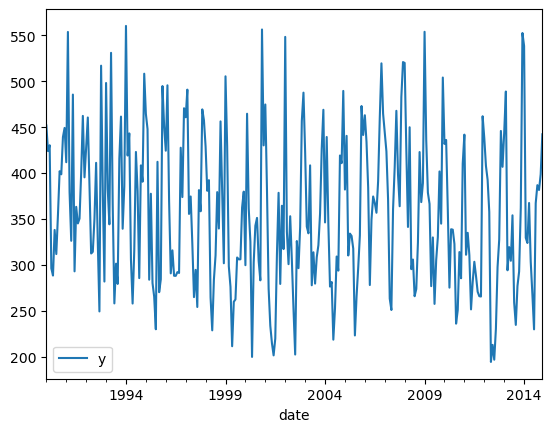

In [7]:
LF.plotTimeSeries()

<Axes: xlabel='date'>

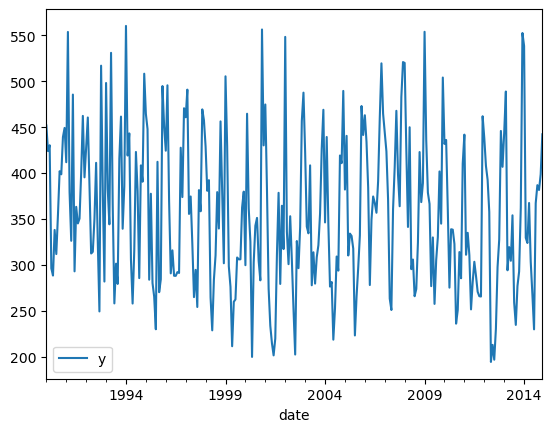

In [8]:
LF.setTimeSeriesSlice()
LF.plotTimeSeries()

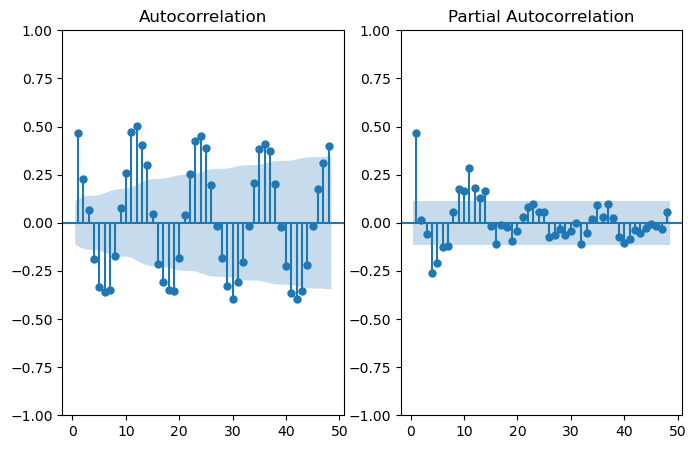

In [9]:
LF.plot_acf_pacf(kwargs={'lags': 48})

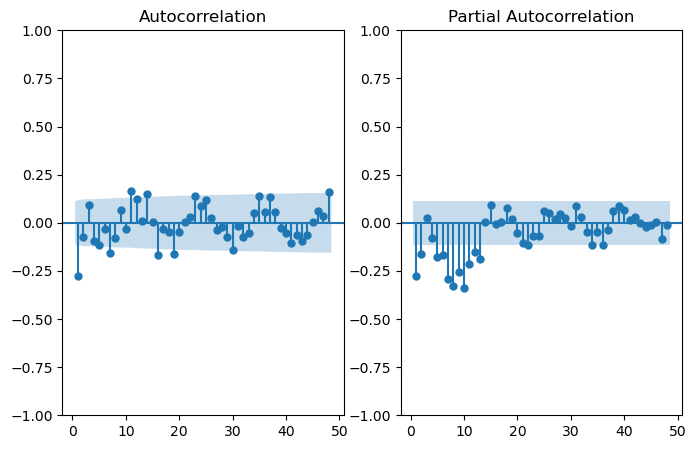

In [10]:
LF.plot_acf_pacf(1, kwargs={'lags': 48})

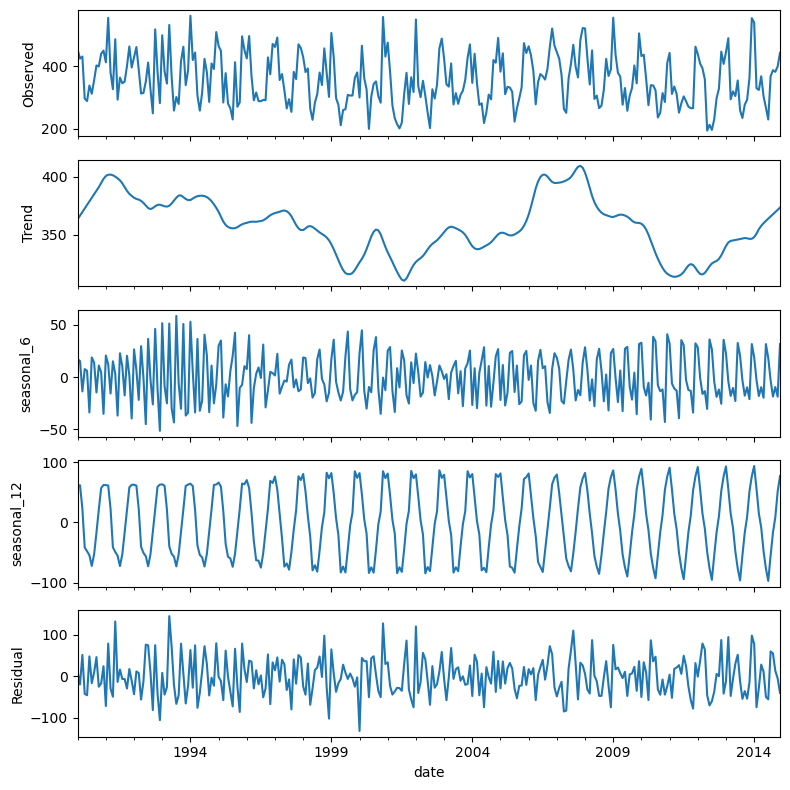

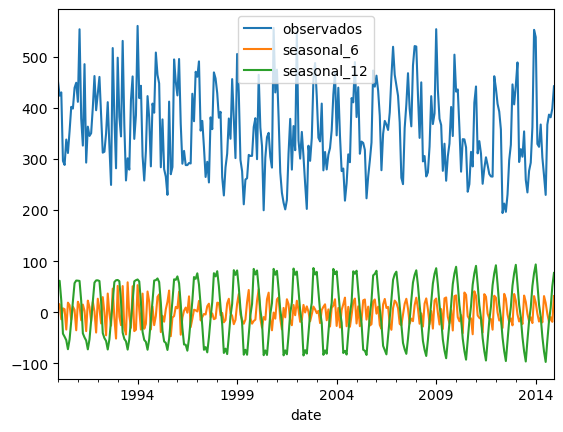

In [11]:
LF.seasonalDecompose((6, 12))

seasonal_6 

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary
Non-differentiated


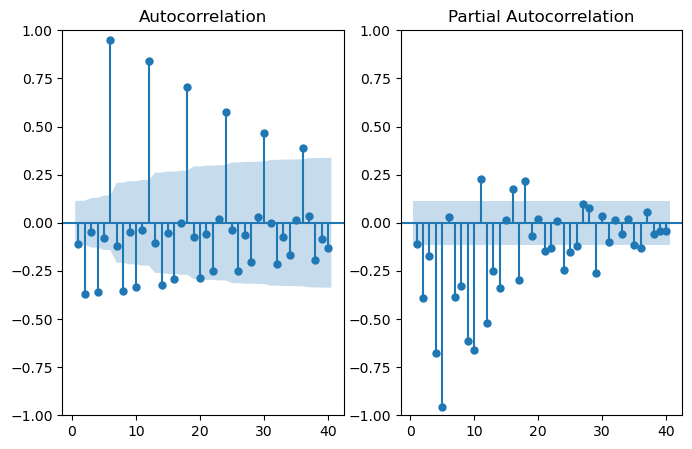

Differentiated


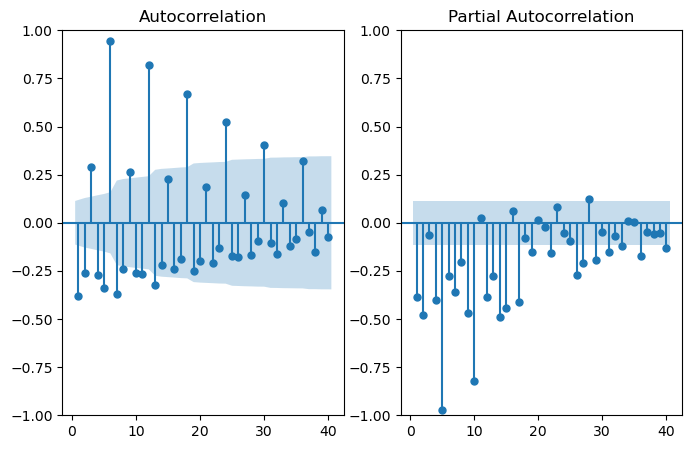





seasonal_12 

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary
Non-differentiated


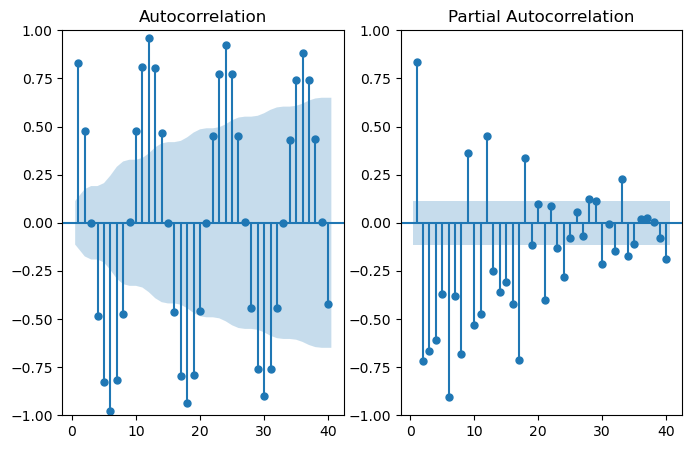

Differentiated


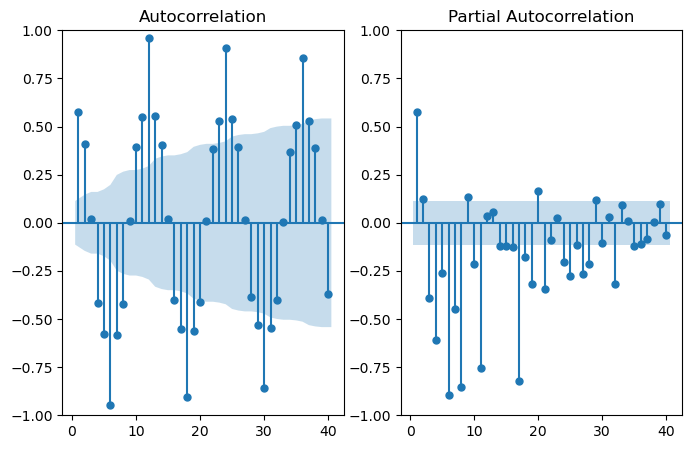

In [12]:
LF.checkStationary()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary
Non-differentiated


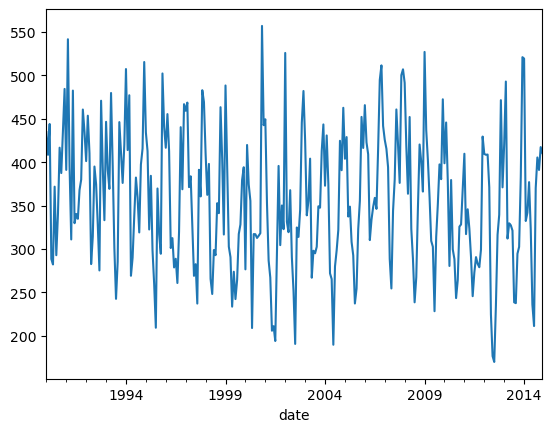

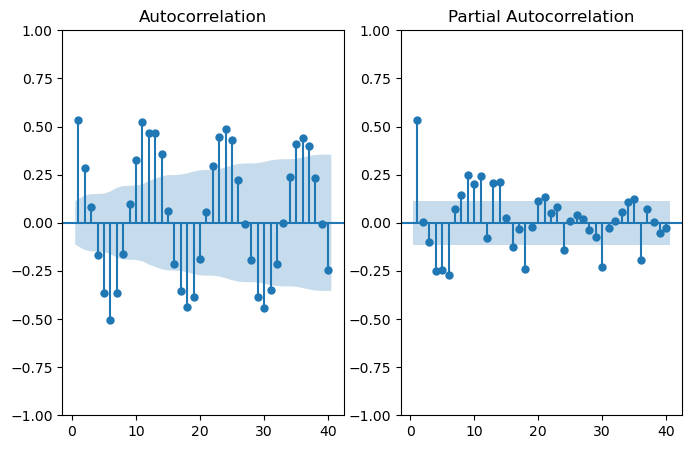

Differentiated


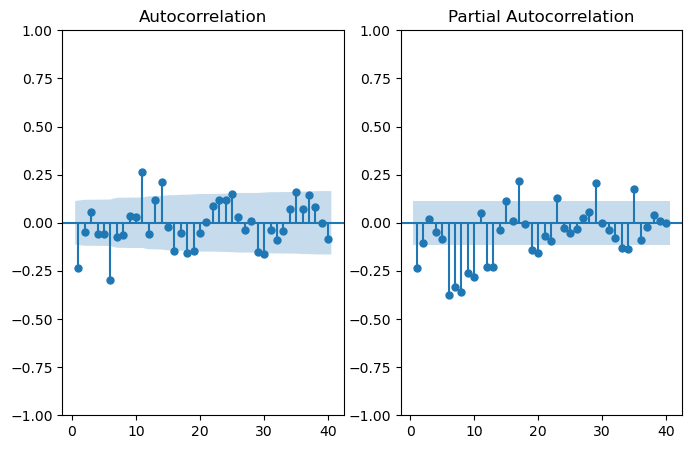

Differentiated x2


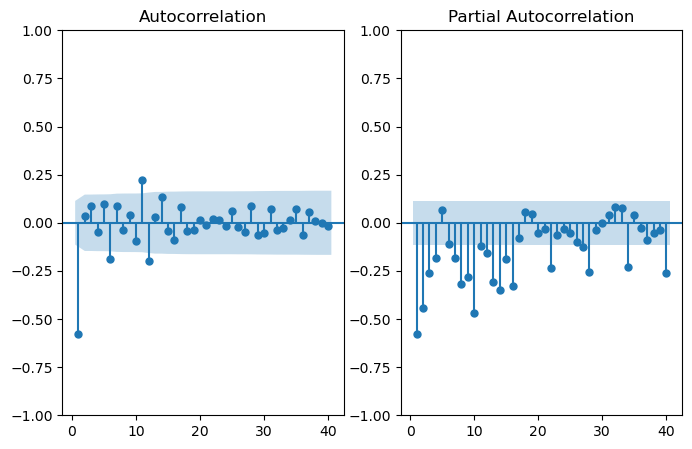

In [13]:
LF.nonStationalComponent(6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


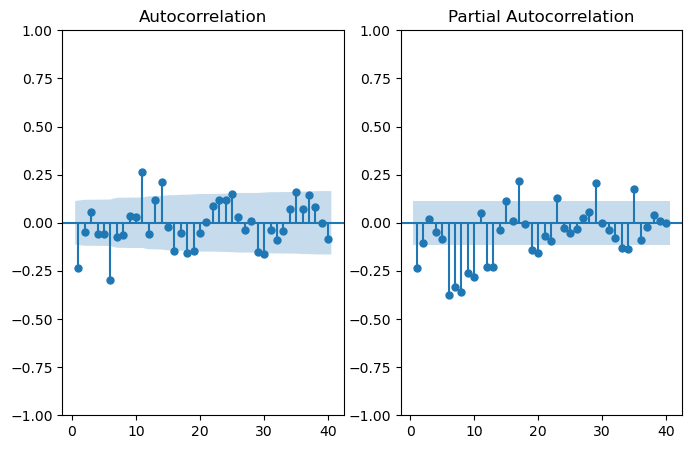

In [14]:
LF.adf_test(False, LF.non_seasonal.diff().dropna())
LF.plot_acf_pacf(1, {'lags': 40}, False, LF.non_seasonal)

In [26]:
p = [0, 1, 2]
d = [1]
q = [0, 1, 2]
P = [0 ,1, 2]
D = [0]
Q = [0, 1, 2]
LF.sarimaxParameters(p, d, q, P, D, Q)

In [27]:
optparams = LF.findParams().sort_values(by=['AIC'], ascending=True)
optparams

Trying out 324 posible combinations
Model done for params: (0, 1, 0), (0, 0, 0, 6), n
Model done for params: (0, 1, 0), (0, 0, 0, 6), c
Model done for params: (0, 1, 0), (0, 0, 0, 6), t
Model done for params: (0, 1, 0), (0, 0, 0, 6), ct
Model done for params: (0, 1, 0), (0, 0, 1, 6), n
Model done for params: (0, 1, 0), (0, 0, 1, 6), c
Model done for params: (0, 1, 0), (0, 0, 1, 6), t
Model done for params: (0, 1, 0), (0, 0, 1, 6), ct
Model done for params: (0, 1, 0), (0, 0, 2, 6), n
Model done for params: (0, 1, 0), (0, 0, 2, 6), c
Model done for params: (0, 1, 0), (0, 0, 2, 6), t
Model done for params: (0, 1, 0), (0, 0, 2, 6), ct
Model done for params: (0, 1, 0), (1, 0, 0, 6), n
Model done for params: (0, 1, 0), (1, 0, 0, 6), c
Model done for params: (0, 1, 0), (1, 0, 0, 6), t
Model done for params: (0, 1, 0), (1, 0, 0, 6), ct
Model done for params: (0, 1, 0), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 2, 6), c
Model done for params: (0, 1, 0), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (1, 0, 2, 6), ct
Model done for params: (0, 1, 0), (2, 0, 0, 6), n
Model done for params: (0, 1, 0), (2, 0, 0, 6), c
Model done for params: (0, 1, 0), (2, 0, 0, 6), t
Model done for params: (0, 1, 0), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 0), (2, 0, 2, 6), ct
Model done for params: (0, 1, 1), (0, 0, 0, 6), n
Model done for params: (0, 1, 1), (0, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (0, 0, 0, 6), t
Model done for params: (0, 1, 1), (0, 0, 0, 6), ct
Model done for params: (0, 1, 1), (0, 0, 1, 6), n
Model done for params: (0, 1, 1), (0, 0, 1, 6), c
Model done for params: (0, 1, 1), (0, 0, 1, 6), t
Model done for params: (0, 1, 1), (0, 0, 1, 6), ct
Model done for params: (0, 1, 1), (0, 0, 2, 6), n
Model done for params: (0, 1, 1), (0, 0, 2, 6), c
Model done for params: (0, 1, 1), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (0, 0, 2, 6), ct
Model done for params: (0, 1, 1), (1, 0, 0, 6), n
Model done for params: (0, 1, 1), (1, 0, 0, 6), c
Model done for params: (0, 1, 1), (1, 0, 0, 6), t
Model done for params: (0, 1, 1), (1, 0, 0, 6), ct
Model done for params: (0, 1, 1), (1, 0, 1, 6), n
Model done for params: (0, 1, 1), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 1, 6), ct
Model done for params: (0, 1, 1), (1, 0, 2, 6), n
Model done for params: (0, 1, 1), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (1, 0, 2, 6), ct
Model done for params: (0, 1, 1), (2, 0, 0, 6), n
Model done for params: (0, 1, 1), (2, 0, 0, 6), c
Model done for params: (0, 1, 1), (2, 0, 0, 6), t
Model done for params: (0, 1, 1), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 1, 6), n
Model done for params: (0, 1, 1), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 1, 6), ct
Model done for params: (0, 1, 1), (2, 0, 2, 6), n
Model done for params: (0, 1, 1), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 1), (2, 0, 2, 6), ct
Model done for params: (0, 1, 2), (0, 0, 0, 6), n
Model done for params: (0, 1, 2), (0, 0, 0, 6), c
Model done for params: (0, 1, 2), (0, 0, 0, 6), t
Model done for params: (0, 1, 2), (0, 0, 0, 6), ct
Model done for params: (0, 1, 2), (0, 0, 1, 6), n
Model done for params: (0, 1, 2), (0, 0, 1, 6), c
Model done for params: (0, 1, 2), (0, 0, 1, 6), t
Model done for params: (0, 1, 2), (0, 0, 1, 6), ct
Model done for params: (0, 1, 2), (0, 0, 2, 6), n
Model done for params: (0, 1, 2), (0, 0, 2, 6), c
Model done for params: (0, 1, 2), (0, 0, 2, 6), t
Model done for params: (0, 1, 2), (0, 0, 2, 6), ct
Model done for params: (0, 1, 2), (1, 0, 0, 6), n
Model done for params: (0, 1, 2), (1, 0, 0, 6), c
Model done for params: (0, 1, 2), (1, 0, 0, 6), t
Model done for params: (0, 1, 2), (1, 0, 0, 6), ct
Model done for params: (0, 1, 2), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 1, 6), ct
Model done for params: (0, 1, 2), (1, 0, 2, 6), n
Model done for params: (0, 1, 2), (1, 0, 2, 6), c
Model done for params: (0, 1, 2), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (1, 0, 2, 6), ct
Model done for params: (0, 1, 2), (2, 0, 0, 6), n
Model done for params: (0, 1, 2), (2, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 0, 6), t
Model done for params: (0, 1, 2), (2, 0, 0, 6), ct
Model done for params: (0, 1, 2), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 1, 6), c
Model done for params: (0, 1, 2), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 1, 6), ct
Model done for params: (0, 1, 2), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (0, 1, 2), (2, 0, 2, 6), t
Model done for params: (0, 1, 2), (2, 0, 2, 6), ct
Model done for params: (1, 1, 0), (0, 0, 0, 6), n
Model done for params: (1, 1, 0), (0, 0, 0, 6), c
Model done for params: (1, 1, 0), (0, 0, 0, 6), t
Model done for params: (1, 1, 0), (0, 0, 0, 6), ct
Model done for params: (1, 1, 0), (0, 0, 1, 6), n
Model done for params: (1, 1, 0), (0, 0, 1, 6), c
Model done for params: (1, 1, 0), (0, 0, 1, 6), t
Model done for params: (1, 1, 0), (0, 0, 1, 6), ct
Model done for params: (1, 1, 0), (0, 0, 2, 6), n
Model done for params: (1, 1, 0), (0, 0, 2, 6), c
Model done for params: (1, 1, 0), (0, 0, 2, 6), t
Model done for params: (1, 1, 0), (0, 0, 2, 6), ct
Model done for params: (1, 1, 0), (1, 0, 0, 6), n
Model done for params: (1, 1, 0), (1, 0, 0, 6), c
Model done for params: (1, 1, 0), (1, 0, 0, 6), t
Model done for params: (1, 1, 0), (1, 0, 0, 6), ct
Model done for params: (1, 1, 0), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 1, 6), ct
Model done for params: (1, 1, 0), (1, 0, 2, 6), n
Model done for params: (1, 1, 0), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (1, 0, 2, 6), ct
Model done for params: (1, 1, 0), (2, 0, 0, 6), n
Model done for params: (1, 1, 0), (2, 0, 0, 6), c
Model done for params: (1, 1, 0), (2, 0, 0, 6), t
Model done for params: (1, 1, 0), (2, 0, 0, 6), ct
Model done for params: (1, 1, 0), (2, 0, 1, 6), n
Model done for params: (1, 1, 0), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 1, 6), ct
Model done for params: (1, 1, 0), (2, 0, 2, 6), n
Model done for params: (1, 1, 0), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 0), (2, 0, 2, 6), ct
Model done for params: (1, 1, 1), (0, 0, 0, 6), n
Model done for params: (1, 1, 1), (0, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 0, 6), t
Model done for params: (1, 1, 1), (0, 0, 0, 6), ct
Model done for params: (1, 1, 1), (0, 0, 1, 6), n
Model done for params: (1, 1, 1), (0, 0, 1, 6), c
Model done for params: (1, 1, 1), (0, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 1, 6), ct
Model done for params: (1, 1, 1), (0, 0, 2, 6), n
Model done for params: (1, 1, 1), (0, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (0, 0, 2, 6), ct
Model done for params: (1, 1, 1), (1, 0, 0, 6), n
Model done for params: (1, 1, 1), (1, 0, 0, 6), c
Model done for params: (1, 1, 1), (1, 0, 0, 6), t
Model done for params: (1, 1, 1), (1, 0, 0, 6), ct
Model done for params: (1, 1, 1), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 1, 6), ct
Model done for params: (1, 1, 1), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (1, 0, 2, 6), ct
Model done for params: (1, 1, 1), (2, 0, 0, 6), n
Model done for params: (1, 1, 1), (2, 0, 0, 6), c
Model done for params: (1, 1, 1), (2, 0, 0, 6), t
Model done for params: (1, 1, 1), (2, 0, 0, 6), ct
Model done for params: (1, 1, 1), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 1, 6), ct
Model done for params: (1, 1, 1), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 2, 6), c
Model done for params: (1, 1, 1), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 1), (2, 0, 2, 6), ct
Model done for params: (1, 1, 2), (0, 0, 0, 6), n
Model done for params: (1, 1, 2), (0, 0, 0, 6), c
Model done for params: (1, 1, 2), (0, 0, 0, 6), t
Model done for params: (1, 1, 2), (0, 0, 0, 6), ct
Model done for params: (1, 1, 2), (0, 0, 1, 6), n
Model done for params: (1, 1, 2), (0, 0, 1, 6), c
Model done for params: (1, 1, 2), (0, 0, 1, 6), t
Model done for params: (1, 1, 2), (0, 0, 1, 6), ct
Model done for params: (1, 1, 2), (0, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (0, 0, 2, 6), c
Model done for params: (1, 1, 2), (0, 0, 2, 6), t
Model done for params: (1, 1, 2), (0, 0, 2, 6), ct
Model done for params: (1, 1, 2), (1, 0, 0, 6), n
Model done for params: (1, 1, 2), (1, 0, 0, 6), c
Model done for params: (1, 1, 2), (1, 0, 0, 6), t
Model done for params: (1, 1, 2), (1, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 1, 6), n
Model done for params: (1, 1, 2), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 2, 6), c
Model done for params: (1, 1, 2), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (1, 0, 2, 6), ct
Model done for params: (1, 1, 2), (2, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 0, 6), c
Model done for params: (1, 1, 2), (2, 0, 0, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 1, 6), n
Model done for params: (1, 1, 2), (2, 0, 1, 6), c
Model done for params: (1, 1, 2), (2, 0, 1, 6), t
Model done for params: (1, 1, 2), (2, 0, 1, 6), ct
Model done for params: (1, 1, 2), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (1, 1, 2), (2, 0, 2, 6), ct
Model done for params: (2, 1, 0), (0, 0, 0, 6), n
Model done for params: (2, 1, 0), (0, 0, 0, 6), c
Model done for params: (2, 1, 0), (0, 0, 0, 6), t
Model done for params: (2, 1, 0), (0, 0, 0, 6), ct
Model done for params: (2, 1, 0), (0, 0, 1, 6), n
Model done for params: (2, 1, 0), (0, 0, 1, 6), c
Model done for params: (2, 1, 0), (0, 0, 1, 6), t
Model done for params: (2, 1, 0), (0, 0, 1, 6), ct
Model done for params: (2, 1, 0), (0, 0, 2, 6), n
Model done for params: (2, 1, 0), (0, 0, 2, 6), c
Model done for params: (2, 1, 0), (0, 0, 2, 6), t
Model done for params: (2, 1, 0), (0, 0, 2, 6), ct
Model done for params: (2, 1, 0), (1, 0, 0, 6), n
Model done for params: (2, 1, 0), (1, 0, 0, 6), c
Model done for params: (2, 1, 0), (1, 0, 0, 6), t
Model done for params: (2, 1, 0), (1, 0, 0, 6), ct
Model done for params: (2, 1, 0), (1, 0, 1, 6), n
Model done for params: (2, 1, 0), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 1, 6), ct
Model done for params: (2, 1, 0), (1, 0, 2, 6), n
Model done for params: (2, 1, 0), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (1, 0, 2, 6), ct
Model done for params: (2, 1, 0), (2, 0, 0, 6), n
Model done for params: (2, 1, 0), (2, 0, 0, 6), c
Model done for params: (2, 1, 0), (2, 0, 0, 6), t
Model done for params: (2, 1, 0), (2, 0, 0, 6), ct
Model done for params: (2, 1, 0), (2, 0, 1, 6), n
Model done for params: (2, 1, 0), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 1, 6), ct
Model done for params: (2, 1, 0), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 0), (2, 0, 2, 6), ct
Model done for params: (2, 1, 1), (0, 0, 0, 6), n
Model done for params: (2, 1, 1), (0, 0, 0, 6), c
Model done for params: (2, 1, 1), (0, 0, 0, 6), t
Model done for params: (2, 1, 1), (0, 0, 0, 6), ct
Model done for params: (2, 1, 1), (0, 0, 1, 6), n
Model done for params: (2, 1, 1), (0, 0, 1, 6), c
Model done for params: (2, 1, 1), (0, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 1, 6), ct
Model done for params: (2, 1, 1), (0, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (0, 0, 2, 6), ct
Model done for params: (2, 1, 1), (1, 0, 0, 6), n
Model done for params: (2, 1, 1), (1, 0, 0, 6), c
Model done for params: (2, 1, 1), (1, 0, 0, 6), t
Model done for params: (2, 1, 1), (1, 0, 0, 6), ct
Model done for params: (2, 1, 1), (1, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 1, 6), ct
Model done for params: (2, 1, 1), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (1, 0, 2, 6), ct
Model done for params: (2, 1, 1), (2, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 0, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 0, 6), ct
Model done for params: (2, 1, 1), (2, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 1, 6), ct
Model done for params: (2, 1, 1), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 1), (2, 0, 2, 6), ct
Model done for params: (2, 1, 2), (0, 0, 0, 6), n
Model done for params: (2, 1, 2), (0, 0, 0, 6), c
Model done for params: (2, 1, 2), (0, 0, 0, 6), t
Model done for params: (2, 1, 2), (0, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 1, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 1, 6), c
Model done for params: (2, 1, 2), (0, 0, 1, 6), t
Model done for params: (2, 1, 2), (0, 0, 1, 6), ct
Model done for params: (2, 1, 2), (0, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (0, 0, 2, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 0, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 0, 6), t
Model done for params: (2, 1, 2), (1, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 1, 6), n
Model done for params: (2, 1, 2), (1, 0, 1, 6), c
Model done for params: (2, 1, 2), (1, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 1, 6), ct
Model done for params: (2, 1, 2), (1, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 2, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (1, 0, 2, 6), ct
Model done for params: (2, 1, 2), (2, 0, 0, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 0, 6), c
Model done for params: (2, 1, 2), (2, 0, 0, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 0, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 1, 6), n
Model done for params: (2, 1, 2), (2, 0, 1, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 1, 6), t


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 1, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 2, 6), n


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 2, 6), c


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model done for params: (2, 1, 2), (2, 0, 2, 6), t
Model done for params: (2, 1, 2), (2, 0, 2, 6), ct


C:\Users\hecto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,params,AIC,BIC,LLF
88,"((0, 1, 2), (1, 0, 1, 6), 'n')",684.798396,703.300614,-337.399198
268,"((2, 1, 1), (1, 0, 1, 6), 'n')",685.100934,707.303595,-336.550467
196,"((1, 1, 2), (1, 0, 1, 6), 'n')",685.130263,707.332924,-336.565131
200,"((1, 1, 2), (1, 0, 2, 6), 'n')",686.581172,712.484277,-336.290586
104,"((0, 1, 2), (2, 0, 2, 6), 'n')",686.631568,712.534673,-336.315784
...,...,...,...,...
6,"((0, 1, 0), (0, 0, 1, 6), 't')",857.432005,868.533336,-425.716002
5,"((0, 1, 0), (0, 0, 1, 6), 'c')",857.441577,868.542907,-425.720788
3,"((0, 1, 0), (0, 0, 0, 6), 'ct')",858.104583,869.205914,-426.052292
15,"((0, 1, 0), (1, 0, 0, 6), 'ct')",859.219988,874.021762,-425.609994


In [28]:
LF.sarimaxModel((0, 1, 2), (1, 0, 1, 6), 'n')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 6)   Log Likelihood                -327.591
Date:                             Thu, 15 Feb 2024   AIC                            665.183
Time:                                     16:39:09   BIC                            683.532
Sample:                                          0   HQIC                           672.534
                                             - 300                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8354      0.060    -13.967      0.000      -0.953      -0.718
ma.L2         -0.0927      0.065     -1.436      0.151      -0.219       0.034
ar.S.L6       -1.0033      0.005   -212.752      0.000      -1.013      -0.994
ma.S.L6        1.0000   1.34e+04   7.46e-05      1.000   -2.63e+04    2.63e+04
sigma2         0.5178   6944.636   7.46e-05      1.000   -1.36e+04    1.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.81   Prob(JB):                         0.44
Heteroskedasticity (H):               0.90   Skew:                             0.13
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

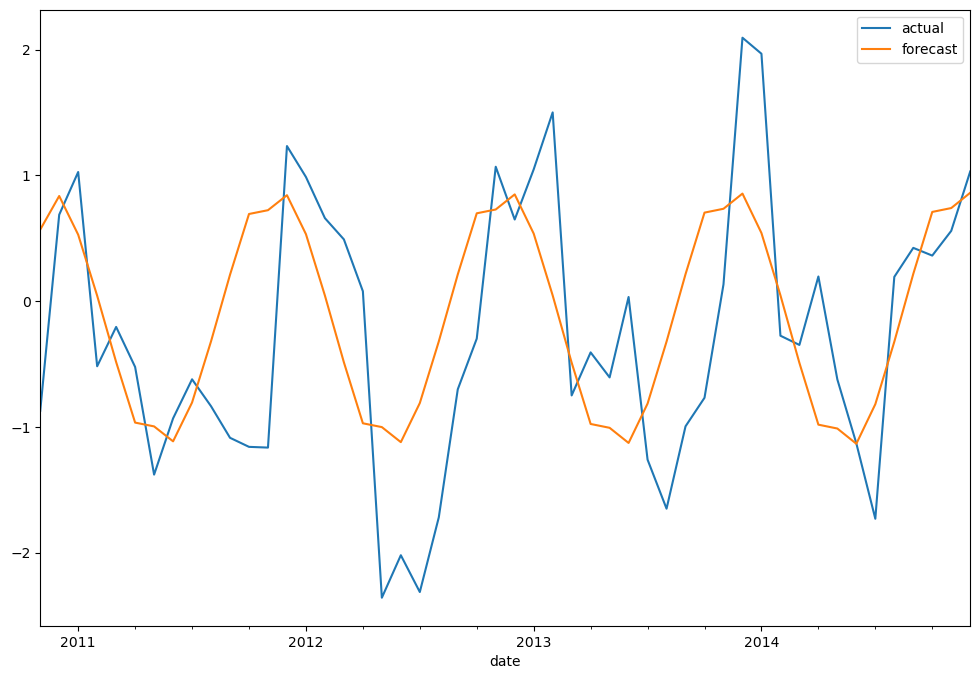

In [29]:
LF.prediction(50)

In [30]:
LF.errors()

MAPE: 199.04 
 MAD: 74.44
